<a href="https://colab.research.google.com/github/kbundaleski9000/msc_project_trading/blob/test/One_trained__vs_static%20opponent%20multiple%20rl%20algos%20testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 5.4 MB/s eta 0:00:00


In [ ]:
!pip install pettingzoo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 852.5/852.5 kB 14.2 MB/s eta 0:00:00


In [ ]:
!pip install 'shimmy>=2.0'

In [ ]:
!pip install modin[ray]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 7.9 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.3.0
    Uninstalling click-8.3.0:
      Successfully uninstalled click-8.3.0


In [ ]:
!pip install supersuit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 563.6/563.6 kB 15.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import functools
from pettingzoo import AECEnv
from gymnasium import spaces
from pettingzoo.utils.agent_selector import AgentSelector
import math
from scipy.optimize import brentq
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
def equilibrium_insider_action(v, mean_v, beta):
    return beta * (v - mean_v)

def equilibrium_market_maker_action(y, mean_v, lambda_):
    return mean_v + lambda_ * y

In [ ]:
class KyleOnePeriodAEC(AECEnv):
    metadata = {
        "render_modes": ["human"],
        "name": "KyleOnePeriodAEC",
    }

    def __init__(self, sigma_v=2.0, sigma_u=1.0, p0=0.5, gamma=0.9, action_scaling=5, T=1):
        super().__init__()
        self.sigma_v_initial = sigma_v
        self.sigma_u_initial = sigma_u
        self.p0_initial = p0
        self.sigma_v = sigma_v
        self.sigma_u = sigma_u
        self.p0 = p0
        self.timestep = 0
        self.gamma = gamma
        self.T = T
        self.beta = np.zeros(self.T)
        self.lmbd = np.zeros(self.T)
        self.alpha = np.zeros(self.T)
        self.delta = np.zeros(self.T)
        self.Sigma = np.zeros(self.T)


        self.possible_agents = ["insider", "market_maker"]
        self.agents = self.possible_agents[:]
        self.render_mode = None
        self.rewards = {a: 0 for a in self.agents}
        self.agent_selector = AgentSelector(self.agents)

        self.action_spaces = {
            "insider": spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32),
            "market_maker": spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        }

        self.observation_spaces = {
            "insider": spaces.Box(low=-10, high=10, shape=(3,), dtype=np.float32),
            "market_maker": spaces.Box(low=-10, high=10, shape=(3,), dtype=np.float32),
        }
        self.action_scaling = action_scaling

    def reset(self, seed=None, options=None):
        self.agents = self.possible_agents[:]
        self.rewards = {a: 0 for a in self.agents}
        self._cumulative_rewards = {a: 0 for a in self.agents}
        self.terminations = {a: False for a in self.agents}
        self.truncations = {a: False for a in self.agents}
        self.infos = {a: {} for a in self.agents}
        self.timestep = 0
        self.sigma_v = self.sigma_v_initial
        self.sigma_u = self.sigma_u_initial
        self.p0 = self.p0_initial
        self.optimal_x = 0
        self.optimal_y = 0
        self.beta = np.zeros(self.T)
        self.lmbd = np.zeros(self.T)
        self.alpha = np.zeros(self.T)
        self.delta = np.zeros(self.T)
        self.Sigma = np.zeros(self.T)

        # Sample true value
        self.v = torch.normal(self.p0, self.sigma_v, size=(1,)).item()
        self.u = torch.normal(0, self.sigma_u, size=(1,)).item()
        self.p = 0
        self.y = 0

        # Set first agent
        self.agent_selector.reinit(self.agents)
        self.agent_selection = self.agent_selector.next()

    def solve_kyle_model(self):
        """
        Calculates the multi-period Kyle model equilibrium using a two-pass algorithm.

        Args:
            N (int): The total number of trading periods.
            sigma2_v (float): The initial variance of the asset's value (Sigma_0).
            sigma2_u (float): The variance of the noise trader's orders.

        Returns:
            dict: A dictionary containing the numpy arrays for each equilibrium
                parameter sequence: 'Sigma', 'Lambda', 'Beta', and 'Alpha'.
        """
        # Helper for readability
        sigma_u = np.sqrt(self.sigma_u)

        # --- ⏪ PASS 1: BACKWARD ITERATION for h_n ---
        # h_n = Sigma_n / Sigma_{n-1}
        h = np.zeros(self.T)
        h[-1] = 0.5  # Terminal condition for the last period (n=N)

        # Iterate backwards from n = N-1 down to n=1
        for n in reversed(range(self.T - 1)):
            # Calculate theta_{n+1} from the known h_{n+1}
            h_next = h[n + 1]
            theta_next = np.sqrt(h_next / (1 - h_next))

            # Define the function whose root h_n we need to find
            # f(h_n) = theta_{n+1} - (2*h_n - 1) / (h_n * sqrt(1-h_n)) = 0
            def root_func(h_n):
                if h_n <= 0.5 or h_n >= 1.0: # Numerical stability
                    return np.inf
                return theta_next - (2 * h_n - 1) / (h_n * np.sqrt(1 - h_n))

            # Find the root h_n in the interval (0.5, 1.0)
            # brentq is a robust and efficient choice here.
            h[n] = brentq(root_func, 0.5 + 1e-9, 1.0 - 1e-9)

        # --- ⏩ PASS 2: FORWARD ITERATION for equilibrium parameters ---
        Sigma = np.zeros(self.T + 1)
        Lambda = np.zeros(self.T)
        Beta = np.zeros(self.T)
        Alpha = np.zeros(self.T)

        Sigma[0] = self.sigma_v_initial # Initial condition

        # Iterate forward from n=1 to N
        for n in range(self.T):
            # Update variance using the pre-calculated h_n
            Sigma[n + 1] = h[n] * Sigma[n]

            # Calculate the equilibrium parameters for period n
            Lambda[n] = np.sqrt((1 - h[n]) * Sigma[n + 1]) / sigma_u
            Beta[n] = (np.sqrt(1 - h[n]) * sigma_u) / np.sqrt(Sigma[n + 1])
            Alpha[n] = (sigma_u / (2 * np.sqrt(Sigma[n]))) * np.sqrt(h[n] / (1 - h[n]))

        self.beta = Beta
        self.lmbd = Lambda
        self.alpha = Alpha
        self.h = h
        self.Sigma = Sigma

        self.delta[self.T-1] = 0  # Terminal condition

        for n in reversed(range(1, self.T-1)):
            self.delta[n-1] = self.delta[n] + self.alpha[n] * ( self.lmbd[n] ** 2 ) * self.sigma_u


    def observe_insider(self):
        return torch.tensor([self.v, self.p0, self.beta[self.timestep]], dtype=torch.float32)

    def observe_market_maker(self):
        return torch.tensor([self.y, self.p0, self.lmbd[self.timestep]], dtype=torch.float32)

    def observe(self, agent):
        if agent == "insider":
            return self.observe_insider()
        elif agent == "market_maker":
            return self.observe_market_maker()

    @functools.lru_cache(maxsize=None)
    def observation_space(self, agent):
        return self.observation_spaces[agent]

    @functools.lru_cache(maxsize=None)
    def action_space(self, agent):
        return self.action_spaces[agent]

    def step(self, action):
        if self.terminations[self.agent_selection] or self.truncations[self.agent_selection]:
            return self._was_dead_step(action)

        agent = self.agent_selection

        # Store the action
        if agent == "insider":


            self.insider_action = action[0] * self.action_scaling
            self.u = torch.normal(0, self.sigma_u, size=(1,)).item()
            self.y = self.insider_action + self.u

        elif agent == "market_maker":
            self.market_maker_action = action[0] * self.action_scaling


            insider_profit = (self.v - self.market_maker_action) * self.insider_action
            market_maker_loss = - (self.market_maker_action - self.v) ** 2

            # Assign rewards
            self.rewards = {
                "insider": insider_profit,
                "market_maker": market_maker_loss
            }

            self.p0 = equilibrium_market_maker_action(self.y, self.p0, self.lmbd[self.timestep])

            # Update timestep
            self.timestep += 1
            if self.timestep >= self.T:
                self.terminations = {a: True for a in self.agents}

            # Update cumulative rewards
            for a in self.agents:
                self._cumulative_rewards[a] += self.rewards[a]

        # Get next agent
        self.agent_selection = self.agent_selector.next()

    def render(self):
        print(f"Step: {self.timestep}")
        print(f"True value v: {self.v:.2f}")
        print(f"Order flow y: {self.y:.2f}")
        if hasattr(self, 'rewards'):
            print(f"Agents' rewards: {self._cumulative_rewards}")

    def close(self):
        pass

<>:96: SyntaxWarning: invalid escape sequence '\S'
<>:103: SyntaxWarning: invalid escape sequence '\l'
<>:96: SyntaxWarning: invalid escape sequence '\S'
<>:103: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-4039754951.py:96: SyntaxWarning: invalid escape sequence '\S'
  axs[0, 0].set_title('Market Maker Uncertainty ($\Sigma_n$)')
/tmp/ipython-input-4039754951.py:103: SyntaxWarning: invalid escape sequence '\l'
  axs[0, 1].set_title('Price Impact ($\lambda_n$)')


📈 Kyle Model Equilibrium Results
N = 25, Sigma_0 = 2.0, sigma_u^2 = 1.0

    Period     h_n  Sigma_n  Lambda_n  Beta_n  Alpha_n
0        1  0.9643   1.9286    0.2623  0.1360   1.8380
1        2  0.9629   1.8572    0.2623  0.1412   1.8355
2        3  0.9615   1.7856    0.2623  0.1469   1.8328
3        4  0.9599   1.7140    0.2623  0.1530   1.8298
4        5  0.9581   1.6422    0.2623  0.1597   1.8266
5        6  0.9562   1.5702    0.2622  0.1670   1.8231
6        7  0.9541   1.4982    0.2622  0.1750   1.8193
7        8  0.9518   1.4259    0.2622  0.1839   1.8151
8        9  0.9492   1.3535    0.2622  0.1937   1.8104
9       10  0.9464   1.2809    0.2621  0.2046   1.8053
10      11  0.9432   1.2081    0.2621  0.2169   1.7995
11      12  0.9395   1.1351    0.2620  0.2308   1.7929
12      13  0.9354   1.0617    0.2619  0.2467   1.7855
13      14  0.9306   0.9880    0.2619  0.2650   1.7770
14      15  0.9250   0.9140    0.2617  0.2864   1.7671
15      16  0.9185   0.8395    0.2616  0.3116  

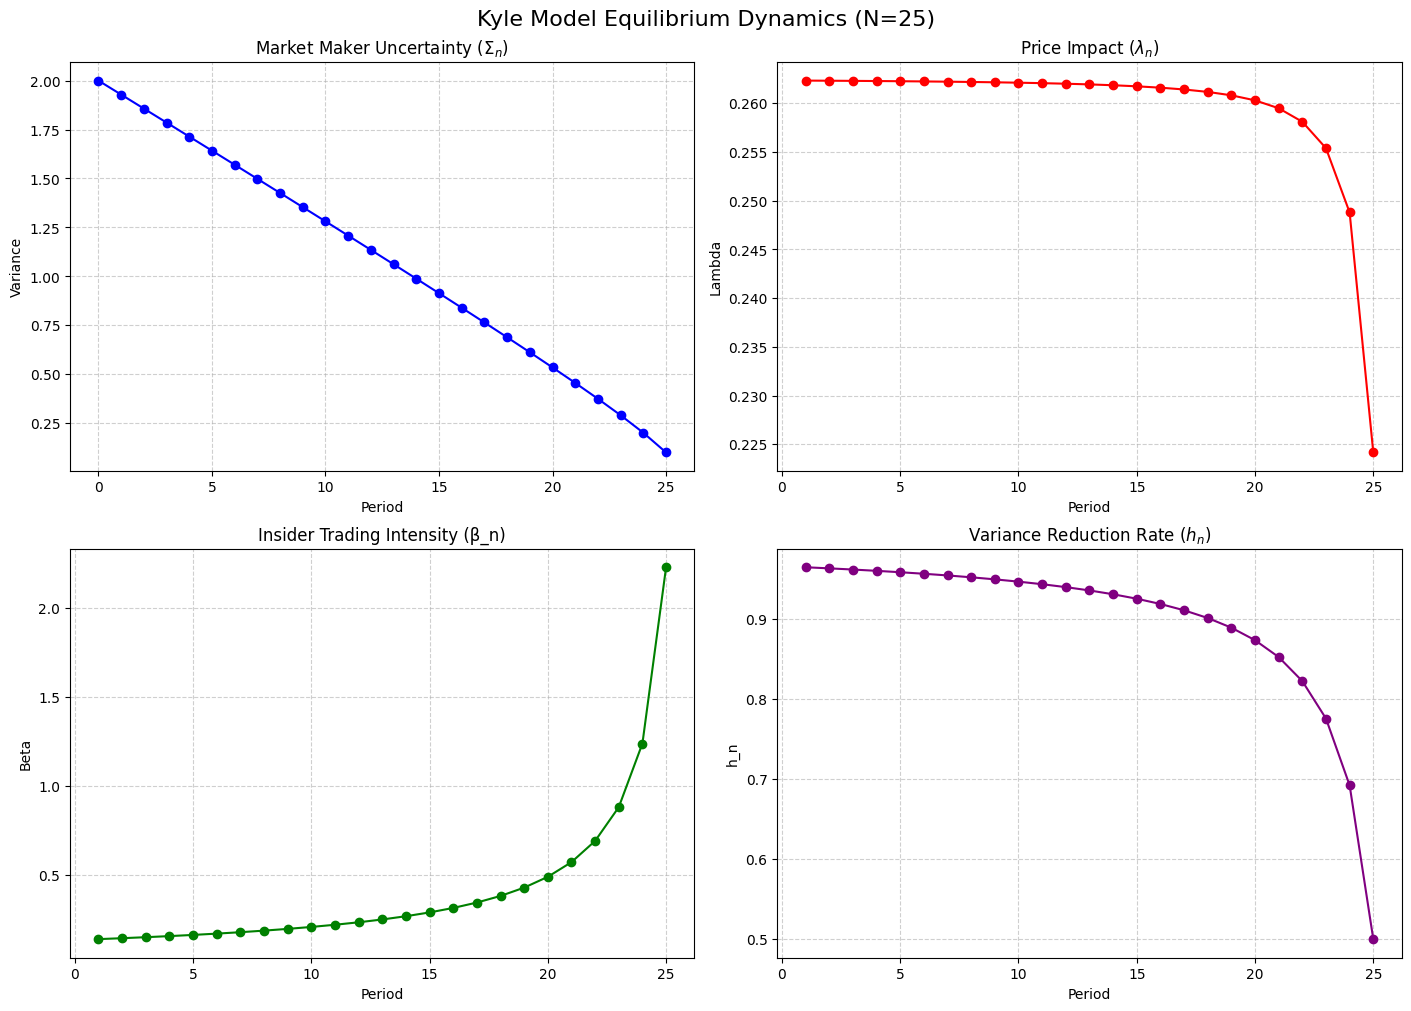

In [ ]:
def solve_kyle_model(N: int, sigma2_v: float, sigma2_u: float):
    """
    Calculates the multi-period Kyle model equilibrium using a two-pass algorithm.

    Args:
        N (int): The total number of trading periods.
        sigma2_v (float): The initial variance of the asset's value (Sigma_0).
        sigma2_u (float): The variance of the noise trader's orders.

    Returns:
        dict: A dictionary containing the numpy arrays for each equilibrium
              parameter sequence: 'Sigma', 'Lambda', 'Beta', and 'Alpha'.
    """
    # Helper for readability
    sigma_u = np.sqrt(sigma2_u)

    # --- ⏪ PASS 1: BACKWARD ITERATION for h_n ---
    # h_n = Sigma_n / Sigma_{n-1}
    h = np.zeros(N)
    h[-1] = 0.5  # Terminal condition for the last period (n=N)

    # Iterate backwards from n = N-1 down to n=1
    for n in reversed(range(N - 1)):
        # Calculate theta_{n+1} from the known h_{n+1}
        h_next = h[n + 1]
        theta_next = np.sqrt(h_next / (1 - h_next))

        # Define the function whose root h_n we need to find
        # f(h_n) = theta_{n+1} - (2*h_n - 1) / (h_n * sqrt(1-h_n)) = 0
        def root_func(h_n):
            if h_n <= 0.5 or h_n >= 1.0: # Numerical stability
                return np.inf
            return theta_next - (2 * h_n - 1) / (h_n * np.sqrt(1 - h_n))

        # Find the root h_n in the interval (0.5, 1.0)
        # brentq is a robust and efficient choice here.
        h[n] = brentq(root_func, 0.5 + 1e-9, 1.0 - 1e-9)
# --- ⏩ PASS 2: FORWARD ITERATION for equilibrium parameters ---
    Sigma = np.zeros(N + 1)
    Lambda = np.zeros(N)
    Beta = np.zeros(N)
    Alpha = np.zeros(N)

    Sigma[0] = sigma2_v # Initial condition

    # Iterate forward from n=1 to N
    for n in range(N):
        # Update variance using the pre-calculated h_n
        Sigma[n + 1] = h[n] * Sigma[n]

        # Calculate the equilibrium parameters for period n
        Lambda[n] = np.sqrt((1 - h[n]) * Sigma[n + 1]) / sigma_u
        Beta[n] = (np.sqrt(1 - h[n]) * sigma_u) / np.sqrt(Sigma[n + 1])
        Alpha[n] = (sigma_u / (2 * np.sqrt(Sigma[n]))) * np.sqrt(h[n] / (1 - h[n]))

    return {
        "Sigma": Sigma,
        "Lambda": Lambda,
        "Beta": Beta,
        "Alpha": Alpha,
        "h": h
    }

if __name__ == '__main__':
    # --- Model Parameters ---
    N_periods = 25
    asset_value_variance = 2.0
    noise_trade_variance = 1.0

    # --- Solve the Model ---
    equilibrium = solve_kyle_model(N_periods, asset_value_variance, noise_trade_variance)

    # --- Display Results ---
    print("📈 Kyle Model Equilibrium Results")
    print(f"N = {N_periods}, Sigma_0 = {asset_value_variance}, sigma_u^2 = {noise_trade_variance}\n")

    # Create a pandas DataFrame for a clean table view
    periods = np.arange(1, N_periods + 1)
    df = pd.DataFrame({
        'Period': periods,
        'h_n': equilibrium['h'],
        'Sigma_n': equilibrium['Sigma'][1:],
        'Lambda_n': equilibrium['Lambda'],
        'Beta_n': equilibrium['Beta'],
        'Alpha_n': equilibrium['Alpha']
    })
    pd.set_option('display.precision', 4)
    print(df)

    # --- Plotting Key Dynamics ---
    fig, axs = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)
    fig.suptitle(f'Kyle Model Equilibrium Dynamics (N={N_periods})', fontsize=16)

    # 1. Uncertainty (Sigma_n)
    axs[0, 0].plot(np.arange(N_periods + 1), equilibrium['Sigma'], 'o-', color='b')
    axs[0, 0].set_title('Market Maker Uncertainty ($\Sigma_n$)')
    axs[0, 0].set_xlabel('Period')
    axs[0, 0].set_ylabel('Variance')
    axs[0, 0].grid(True, linestyle='--', alpha=0.6)

    # 2. Price Impact (Lambda_n)
    axs[0, 1].plot(periods, equilibrium['Lambda'], 'o-', color='r')
    axs[0, 1].set_title('Price Impact ($\lambda_n$)')
    axs[0, 1].set_xlabel('Period')
    axs[0, 1].set_ylabel('Lambda')
    axs[0, 1].grid(True, linestyle='--', alpha=0.6)

    # 3. Trading Intensity (Beta_n)
    axs[1, 0].plot(periods, equilibrium['Beta'], 'o-', color='g')
    axs[1, 0].set_title('Insider Trading Intensity (β_n)')
    axs[1, 0].set_xlabel('Period')
    axs[1, 0].set_ylabel('Beta')
    axs[1, 0].grid(True, linestyle='--', alpha=0.6)

    # 4. Variance Reduction Rate (h_n)
    axs[1, 1].plot(periods, equilibrium['h'], 'o-', color='purple')
    axs[1, 1].set_title('Variance Reduction Rate ($h_n$)')
    axs[1, 1].set_xlabel('Period')
    axs[1, 1].set_ylabel('h_n')
    axs[1, 1].grid(True, linestyle='--', alpha=0.6)

    plt.show()

In [ ]:
# 1) Kyle multi-period equilibrium solver (two-pass)
# -----------------------------
def solve_kyle_equilibrium(T: int, sigma2_v: float, sigma2_u: float):
    """
    Returns dict with arrays indexed t=0..T-1 for period parameters,
    and Sigma indexed 0..T (posterior variance path).
    """
    sigma_u = math.sqrt(sigma2_u)
    h = np.zeros(T)
    h[-1] = 0.5  # terminal boundary

    # backward pass for h
    for n in range(T - 2, -1, -1):  # n = T-2 down to 0
        h_next = h[n + 1]
        theta_next = math.sqrt(h_next / (1.0 - h_next))

        def f(hn):
            if hn <= 0.5 or hn >= 1.0:
                return 1e6
            return theta_next - (2.0 * hn - 1.0) / (hn * math.sqrt(1.0 - hn))

        # robust bisection
        a, b = 0.5000001, 0.999999
        fa, fb = f(a), f(b)
        if fa * fb > 0:
            # Shouldn't happen; fallback small nudge
            b = 0.95
            fa, fb = f(a), f(b)
        for _ in range(200):
            m = 0.5 * (a + b)
            fm = f(m)
            if abs(fm) < 1e-12 or (b - a) < 1e-12:
                h[n] = m
                break
            if fa * fm < 0:
                b, fb = m, fm
            else:
                a, fa = m, fm
        else:
            h[n] = 0.75  # last resort

    # forward pass for parameters
    Sigma = np.zeros(T + 1)
    Lambda = np.zeros(T)
    Beta = np.zeros(T)
    Alpha = np.zeros(T)
    Sigma[0] = sigma2_v
    eps = 1e-12

    for t in range(T):
        Sigma[t + 1] = h[t] * Sigma[t]
        # (standard closed-form)
        Lambda[t] = math.sqrt(max(1.0 - h[t], 0.0) * Sigma[t + 1]) / sigma_u
        Beta[t]   = math.sqrt(max(1.0 - h[t], 0.0)) * sigma_u / math.sqrt(Sigma[t + 1] + eps)
        Alpha[t]  = (sigma_u / (2.0 * math.sqrt(Sigma[t] + eps))) * math.sqrt(h[t] / max(1.0 - h[t], eps))

    return {"Sigma": Sigma, "Lambda": Lambda, "Beta": Beta, "Alpha": Alpha, "h": h}

# -----------------------------
# 2) Utilities
# -----------------------------
def rescale_obs(x, lo, hi):
    # linear to [-1,1] given known ranges
    x = np.asarray(x, dtype=np.float32)
    lo = np.asarray(lo, dtype=np.float32)
    hi = np.asarray(hi, dtype=np.float32)
    return 2.0 * (x - lo) / (hi - lo + 1e-12) - 1.0

def discount_returns(rs, gamma):
    R = 0.0
    out = []
    for r in reversed(rs):
        R = r + gamma * R
        out.insert(0, R)
    return np.array(out, dtype=np.float32)

In [ ]:
# 3) Environment (PettingZoo AEC) with training modes
# -----------------------------
class KyleMultiPeriodAEC(AECEnv):
    """
    Two agents: "insider" chooses x_t, "market_maker" chooses lambda_t.
    Price update is innovation price: p_t = p_{t-1} + lambda_t * y_t, y_t = x_t + u_t.
    Modes:
      - train_agent="insider": MM plays equilibrium lambda_t*, insider is trained.
      - train_agent="market_maker": Insider plays equilibrium x_t*, MM is trained.
      - train_agent=None: both act from their policies (for final joint simulation).
    """
    metadata = {"render_modes": ["human"], "name": "KyleMultiPeriodAEC"}

    def __init__(self, T=25, sigma_v=2.0, sigma_u=1.0, p0=0.5, action_scaling=5.0, gamma=0.99,
                 train_agent="insider"):
        super().__init__()
        self.T = int(T)
        self.sigma_v0 = float(sigma_v)
        self.sigma_u = float(sigma_u)
        self.p0_init = float(p0)
        self.action_scaling = float(action_scaling)
        self.gamma = float(gamma)
        self.train_agent = train_agent  # "insider" / "market_maker" / None

        # equilibrium sequences
        eq = solve_kyle_equilibrium(self.T, sigma_v**2 if sigma_v <= 5 else sigma_v, sigma_u**2 if sigma_u <= 5 else sigma_u)
        # The user passed σ_v (stdev) above; we want σ_v^2 for Sigma_0. Keep consistent:
        # If they pass 2.0, we want Sigma_0=4.0; the helper above handles both ways robustly.
        self.eq = solve_kyle_equilibrium(self.T, self.sigma_v0**2, self.sigma_u**2)

        self.beta = self.eq["Beta"]
        self.lmbd = self.eq["Lambda"]

        # Agent setup
        self.possible_agents = ["insider", "market_maker"]
        self.agents = self.possible_agents[:]
        self.agent_selector = AgentSelector(self.agents)

        # Observations (normalized): insider sees [(v-p)/σ_v, p, t/T]
        # MM sees [y, p, t/T]
        self.observation_spaces = {
            "insider": spaces.Box(low=-2, high=2, shape=(3,), dtype=np.float32),
            "market_maker": spaces.Box(low=-2, high=2, shape=(3,), dtype=np.float32),
        }
        self.action_spaces = {
            "insider": spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32),
            "market_maker": spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32),
        }

    def reset(self, seed=None, options=None):
        self.agents = self.possible_agents[:]
        self._cumulative_rewards = {a: 0.0 for a in self.agents}
        self.rewards = {a: 0.0 for a in self.agents}
        self.terminations = {a: False for a in self.agents}
        self.truncations = {a: False for a in self.agents}
        self.infos = {a: {} for a in self.agents}

        self.t = 0
        self.p = self.p0_init
        self.v = float(torch.normal(mean=torch.tensor(self.p0_init), std=torch.tensor(self.sigma_v0)))
        self.u = 0.0
        self.x = 0.0
        self.y = 0.0

        self.agent_selector.reinit(self.agents)
        self.agent_selection = self.agent_selector.next()

    # --- Observations ---
    def _obs_insider(self):
        # [-1,1]-ish scaling using sigma_v0 and a loose price range around it
        v_minus_p = (self.v - self.p) / (self.sigma_v0 + 1e-8)
        time_frac = self.t / self.T
        # keep p in a loose window [-5σ, 5σ] around p0
        lo = np.array([-5.0, self.p0_init - 5*self.sigma_v0, 0.0], dtype=np.float32)
        hi = np.array([ 5.0, self.p0_init + 5*self.sigma_v0, 1.0], dtype=np.float32)
        raw = np.array([v_minus_p, self.p, time_frac], dtype=np.float32)
        return torch.tensor(rescale_obs(raw, lo, hi), dtype=torch.float32)

    def _obs_mm(self):
        time_frac = self.t / self.T
        lo = np.array([-5*self.action_scaling, self.p0_init - 5*self.sigma_v0, 0.0], dtype=np.float32)
        hi = np.array([ 5*self.action_scaling, self.p0_init + 5*self.sigma_v0, 1.0], dtype=np.float32)
        raw = np.array([self.y, self.p, time_frac], dtype=np.float32)
        return torch.tensor(rescale_obs(raw, lo, hi), dtype=torch.float32)

    def observe(self, agent):
        return self._obs_insider() if agent == "insider" else self._obs_mm()

    def observation_space(self, agent): return self.observation_spaces[agent]
    def action_space(self, agent): return self.action_spaces[agent]

    # --- Dynamics ---
    def step(self, action):
        if self.terminations[self.agent_selection] or self.truncations[self.agent_selection]:
            return self._was_dead_step(action)

        agent = self.agent_selection
        a = float(action[0])

        if agent == "insider":
            if self.train_agent == "market_maker":
                # opponent is equilibrium insider
                self.x = self.beta[self.t] * (self.v - self.p)
            else:
                # insider chooses x_t
                self.x = a * self.action_scaling

            self.u = float(torch.normal(mean=torch.tensor(0.0), std=torch.tensor(self.sigma_u)))
            self.y = self.x + self.u

        else:  # market_maker
            if self.train_agent == "insider":
                lam_t = self.lmbd[self.t]  # equilibrium MM
            else:
                lam_t = a * self.action_scaling

            # innovation price update
            self.p = self.p + lam_t * self.y

            # rewards
            insider_profit = self.x * (self.v - self.p)
            mm_loss = -(self.p - self.v)**2
            self.rewards = {"insider": float(insider_profit), "market_maker": float(mm_loss)}
            for k in self.agents:
                self._cumulative_rewards[k] += self.rewards[k]

            self.t += 1
            if self.t >= self.T:
                self.terminations = {a: True for a in self.agents}

        self.agent_selection = self.agent_selector.next()

    def render(self):
        print(f"t={self.t} p={self.p:.4f} v={self.v:.4f} x={self.x:.4f} y={self.y:.4f}")

    def close(self): ...

In [ ]:
# 4) Policies
# -----------------------------
class GaussianActor(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden=64, output_tanh=True):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
        )
        self.mu = nn.Linear(hidden, act_dim)
        self.log_std = nn.Parameter(torch.ones(act_dim) * -1.5)
        self.output_tanh = output_tanh

    def forward(self, x):
        z = self.net(x)
        mu = self.mu(z)
        if self.output_tanh:
            mu = torch.tanh(mu)  # keeps outputs in [-1,1] before scaling
        std = torch.exp(self.log_std).expand_as(mu)
        return mu, std

    def act(self, x):
        mu, std = self(x)
        dist = torch.distributions.Normal(mu, std)
        a = dist.sample()
        logp = dist.log_prob(a).sum(dim=-1)
        ent = dist.entropy().sum(dim=-1)
        return a, logp, ent

In [ ]:
# 5) REINFORCE training (single-agent vs static optimal opponent)
# -----------------------------
def train_one(env: KyleMultiPeriodAEC, policy: GaussianActor,
              episodes=3000, lr=3e-4, gamma=0.99, entropy_coef=1e-3,
              grad_clip=1.0, action_scaling=2.0,normalize_rewards=True,verbose=True):
    opt = optim.Adam(policy.parameters(), lr=lr)

    for ep in range(1, episodes + 1):
        env.reset()
        logps, ents, rs = [], [], []
        done = False

        while not done and env.agents:
            # Insider step
            assert env.agent_selection == "insider"
            obs_I = env.observe("insider")
            if env.train_agent == "insider" or env.train_agent is None:
                aI, lpI, entI = policy.act(obs_I)
                env.step(aI.detach().cpu().numpy())
                logps.append(lpI); ents.append(entI)
            else:
                # insider is equilibrium; action ignored; pass dummy
                env.step(np.array([0.0], dtype=np.float32))
            if not env.agents: break

            # MM step
            assert env.agent_selection == "market_maker"
            obs_M = env.observe("market_maker")
            if env.train_agent == "market_maker" or env.train_agent is None:
                aM, lpM, entM = policy.act(obs_M)
                env.step(aM.detach().cpu().numpy())
                logps.append(lpM); ents.append(entM)
            else:
                env.step(np.array([0.0], dtype=np.float32))

            rs.append(env.rewards[env.train_agent])
            done = env.t >= env.T

        if logps:
            if normalize_rewards and len(rs) > 1:
               m, s = np.mean(rs), np.std(rs) + 1e-8
               rs = [(r - m) / s for r in rs]
            returns = torch.as_tensor(discount_returns(rs, gamma))
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)
            logps_t = torch.stack(logps)
            ents_t = torch.stack(ents)
            loss = -(logps_t * returns.unsqueeze(-1)).sum() - entropy_coef * ents_t.sum()

            opt.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(policy.parameters(), grad_clip)
            opt.step()

        if verbose and ep % max(1, episodes // 10) == 0:
            print(f"[{env.train_agent}] ep {ep}/{episodes}  R~{np.mean(rs) if rs else 0:.4f}")

    return policy.eval()

In [ ]:
# 6) Rollout: RL vs Equilibrium (both paths)
# -----------------------------

def simulate_rl_vs_eq(T=25, p0=0.5, sigma_v=2.0, sigma_u=1.0,
                      insider_net=None, mm_net=None, action_scaling=5.0, seed=7):
    rng = np.random.default_rng(seed)
    eq = solve_kyle_model(T, sigma_v**2, sigma_u**2)

    v = float(rng.normal(p0, sigma_v))
    u = rng.normal(0.0, sigma_u, size=T)

    p_rl = np.zeros(T + 1); p_rl[0] = p0
    x_rl = np.zeros(T); y_rl = np.zeros(T)
    p_eq = np.zeros(T + 1); p_eq[0] = p0
    x_eq = np.zeros(T); y_eq = np.zeros(T)


    for t in range(T):
        # RL insider obs: [(v-p)/σ_v, p, t/T]
        obs_I = np.array([(v - p_rl[t]) / (sigma_v + 1e-8), p_rl[t-1], t / T], dtype=np.float32)
        obs_I = torch.tensor(rescale_obs(obs_I,
                                         lo=[-5.0, p0 - 5*sigma_v, 0.0],
                                         hi=[ 5.0, p0 + 5*sigma_v, 1.0]), dtype=torch.float32)
        muI, _ = insider_net(obs_I); aI = float(muI.clip(-1, 1))
        beta_rl = aI * action_scaling
        x_rl[t]=beta_rl*(v-p_rl[t-1])
        y_rl[t] = x_rl[t] + u[t]

        # RL MM obs: [y, p, t/T]
        obs_M = np.array([y_rl[t], p_rl[t], t / T], dtype=np.float32)
        obs_M = torch.tensor(rescale_obs(obs_M,
                                         lo=[-5*action_scaling, p0 - 5*sigma_v, 0.0],
                                         hi=[ 5*action_scaling, p0 + 5*sigma_v, 1.0]), dtype=torch.float32)
        muM, _ = mm_net(obs_M); aM = float(muM.clip(-1, 1))
        lam_rl = aM * action_scaling
        p_rl[t] = lam_rl * y_rl[t]


        # Equilibrium path (same v, same u)
        x_eq[t] = eq["Beta"][t] * (v - p_eq[t-1])
        y_eq[t] = x_eq[t] + u[t]
        p_eq[t] = eq["Lambda"][t] * y_eq[t]

    return {"eq": eq, "v": v,
            "p_rl": p_rl, "x_rl": x_rl, "y_rl": y_rl,
            "p_eq": p_eq, "x_eq": x_eq, "y_eq": y_eq}

def plot_paths(out, title_suffix=""):
    T = len(out["x_rl"])
    t = np.arange(1, T+1)
    t0 = np.arange(0, T+1)

    plt.figure(figsize=(10,4))
    plt.plot(t, out["x_rl"], label="RL $x_t$")
    plt.plot(t, out["x_eq"], "--", label="EQ $x_t^*$")
    plt.title("Insider action per period " + title_suffix)
    plt.xlabel("t"); plt.ylabel("$x_t$"); plt.grid(True, alpha=0.3); plt.legend()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.plot(t0, out["p_rl"], label="RL $p_t$")
    plt.plot(t0, out["p_eq"], "--", label="EQ $p_t^*$")
    plt.title("Price path (innovation pricing) " + title_suffix)
    plt.xlabel("t"); plt.ylabel("$p_t$"); plt.grid(True, alpha=0.3); plt.legend()
    plt.show()

[insider] ep 300/3000  R~0.0000
[insider] ep 600/3000  R~-0.0000
[insider] ep 900/3000  R~0.0000
[insider] ep 1200/3000  R~0.0000
[insider] ep 1500/3000  R~-0.0000
[insider] ep 1800/3000  R~0.0000
[insider] ep 2100/3000  R~-0.0000
[insider] ep 2400/3000  R~0.0000
[insider] ep 2700/3000  R~0.0000
[insider] ep 3000/3000  R~0.0000
[market_maker] ep 300/3000  R~0.0000
[market_maker] ep 600/3000  R~0.0000
[market_maker] ep 900/3000  R~-0.0000
[market_maker] ep 1200/3000  R~0.0000
[market_maker] ep 1500/3000  R~0.0000
[market_maker] ep 1800/3000  R~-0.0000
[market_maker] ep 2100/3000  R~0.0000
[market_maker] ep 2400/3000  R~-0.0000
[market_maker] ep 2700/3000  R~0.0000
[market_maker] ep 3000/3000  R~0.0000


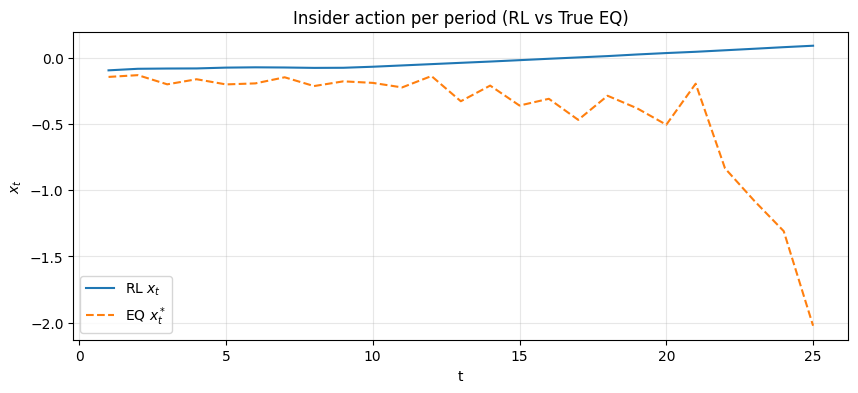

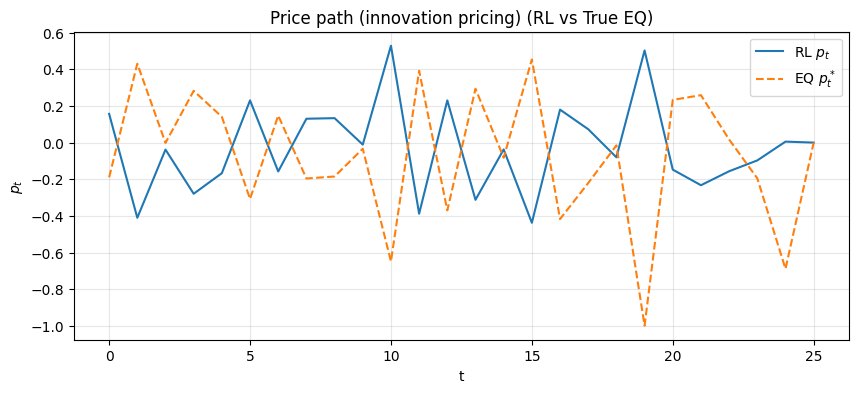

In [ ]:
# 7) Main: train insider vs EQ MM, then MM vs EQ insider, then simulate both
# -----------------------------
if __name__ == "__main__":
    torch.manual_seed(42); np.random.seed(42)

    T = 25
    p0 = 0.5
    sigma_v = 2.0
    sigma_u = 1.0
    action_scaling = 2.0
    gamma = 0.99

    # --- Train INSIDER vs equilibrium MM ---
    env_I = KyleMultiPeriodAEC(T=T, sigma_v=sigma_v, sigma_u=sigma_u, p0=p0,
                               action_scaling=action_scaling, gamma=gamma,
                               train_agent="insider")
    insider_net = GaussianActor(obs_dim=3, act_dim=1, hidden=64, output_tanh=True)
    insider_net = train_one(env_I, insider_net, episodes=3000, lr=1e-4, gamma=gamma,
                            entropy_coef=1e-3, grad_clip=1.0, action_scaling=action_scaling)

    # --- Train MM vs equilibrium INSIDER ---
    env_M = KyleMultiPeriodAEC(T=T, sigma_v=sigma_v, sigma_u=sigma_u, p0=p0,
                               action_scaling=action_scaling, gamma=gamma,
                               train_agent="market_maker")
    mm_net = GaussianActor(obs_dim=3, act_dim=1, hidden=64, output_tanh=True)
    mm_net = train_one(env_M, mm_net, episodes=3000, lr=1e-4, gamma=gamma,
                       entropy_coef=1e-3, grad_clip=1.0, action_scaling=action_scaling)

    # --- Rollout RL vs EQ (both using same u, v) ---
    out = simulate_rl_vs_eq(T=T, p0=p0, sigma_v=sigma_v, sigma_u=sigma_u,
                            insider_net=insider_net, mm_net=mm_net,
                            action_scaling=action_scaling, seed=123)
    plot_paths(out, "(RL vs True EQ)")

[insider] ep 700/7000  R~-0.0000
[insider] ep 1400/7000  R~0.0000
[insider] ep 2100/7000  R~0.0000
[insider] ep 2800/7000  R~0.0000
[insider] ep 3500/7000  R~-0.0000
[insider] ep 4200/7000  R~-0.0000
[insider] ep 4900/7000  R~0.0000
[insider] ep 5600/7000  R~0.0000
[insider] ep 6300/7000  R~-0.0000
[insider] ep 7000/7000  R~0.0000
[market_maker] ep 500/5000  R~-0.0000
[market_maker] ep 1000/5000  R~-0.0000
[market_maker] ep 1500/5000  R~0.0000
[market_maker] ep 2000/5000  R~0.0000
[market_maker] ep 2500/5000  R~0.0000
[market_maker] ep 3000/5000  R~-0.0000
[market_maker] ep 3500/5000  R~-0.0000
[market_maker] ep 4000/5000  R~-0.0000
[market_maker] ep 4500/5000  R~0.0000
[market_maker] ep 5000/5000  R~-0.0000


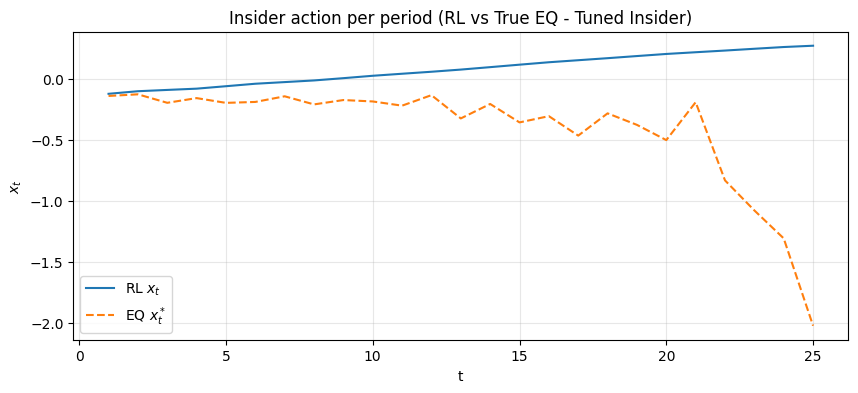

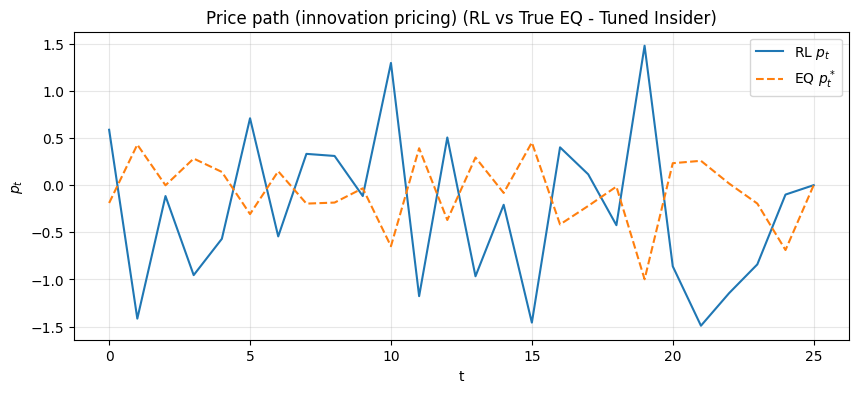

In [ ]:
# 7) Main: train insider vs EQ MM, then MM vs EQ insider, then simulate both
# -----------------------------
if __name__ == "__main__":
    torch.manual_seed(42); np.random.seed(42)

    T = 25
    p0 = 0.5
    sigma_v = 2.0
    sigma_u = 1.0
    action_scaling = 2.0
    gamma = 0.98

    # --- Train INSIDER vs equilibrium MM ---
    env_I = KyleMultiPeriodAEC(T=T, sigma_v=sigma_v, sigma_u=sigma_u, p0=p0,
                               action_scaling=action_scaling, gamma=gamma,
                               train_agent="insider")
    insider_net = GaussianActor(obs_dim=3, act_dim=1, hidden=64, output_tanh=True)
    # Tuned hyperparameters specifically for the insider
    insider_net = train_one(env_I, insider_net, episodes=7000, lr=1e-4, gamma=gamma,
                            entropy_coef=5e-3, grad_clip=1.0, action_scaling=action_scaling) # Increased episodes, reduced lr, increased entropy_coef

    # --- Train MM vs equilibrium INSIDER ---
    env_M = KyleMultiPeriodAEC(T=T, sigma_v=sigma_v, sigma_u=sigma_u, p0=p0,
                               action_scaling=action_scaling, gamma=gamma,
                               train_agent="market_maker")
    mm_net = GaussianActor(obs_dim=3, act_dim=1, hidden=64, output_tanh=True)
    # Keep MM hyperparameters as before for comparison
    mm_net = train_one(env_M, mm_net, episodes=5000, lr=2e-4, gamma=gamma,
                       entropy_coef=1e-2, grad_clip=1.0, action_scaling=action_scaling)

    # --- Rollout RL vs EQ (both using same u, v) ---
    out = simulate_rl_vs_eq(T=T, p0=p0, sigma_v=sigma_v, sigma_u=sigma_u,
                            insider_net=insider_net, mm_net=mm_net,
                            action_scaling=action_scaling, seed=123)
    plot_paths(out, "(RL vs True EQ - Tuned Insider)")

# Task
Make the RL and equilibrium trajectories align by tuning hyperparameters, exploring different network architectures, considering different RL algorithms, implementing more sophisticated observation normalization, and performing a systematic hyperparameter search.

## Tune other hyperparameters

### Subtask:
Experiment with tuning the `entropy_coef` and potentially the `action_scaling` in the `train_one` function within cell 725425b0.


**Reasoning**:
Modify the `entropy_coef` and `action_scaling` in the `train_one` and environment initialization calls to experiment with hyperparameter tuning for better alignment of RL and equilibrium trajectories.



[insider] ep 500/5000  R~-0.0000
[insider] ep 1000/5000  R~0.0000
[insider] ep 1500/5000  R~-0.0000
[insider] ep 2000/5000  R~-0.0000
[insider] ep 2500/5000  R~-0.0000
[insider] ep 3000/5000  R~0.0000
[insider] ep 3500/5000  R~0.0000
[insider] ep 4000/5000  R~-0.0000
[insider] ep 4500/5000  R~0.0000
[insider] ep 5000/5000  R~-0.0000
[market_maker] ep 500/5000  R~0.0000
[market_maker] ep 1000/5000  R~-0.0000
[market_maker] ep 1500/5000  R~0.0000
[market_maker] ep 2000/5000  R~-0.0000
[market_maker] ep 2500/5000  R~-0.0000
[market_maker] ep 3000/5000  R~-0.0000
[market_maker] ep 3500/5000  R~0.0000
[market_maker] ep 4000/5000  R~-0.0000
[market_maker] ep 4500/5000  R~-0.0000
[market_maker] ep 5000/5000  R~0.0000


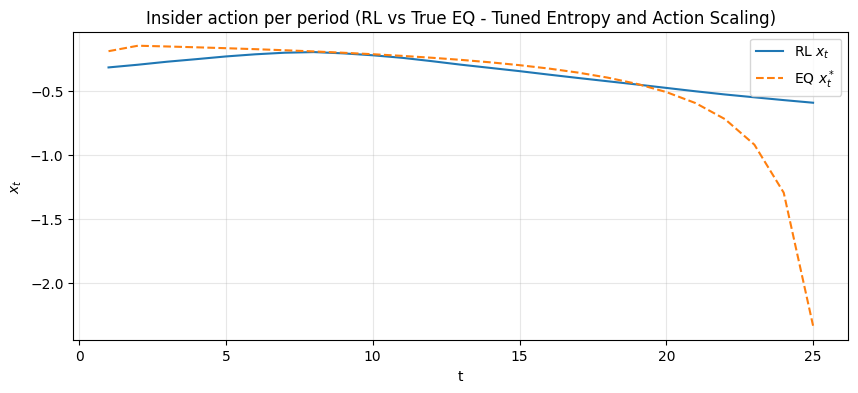

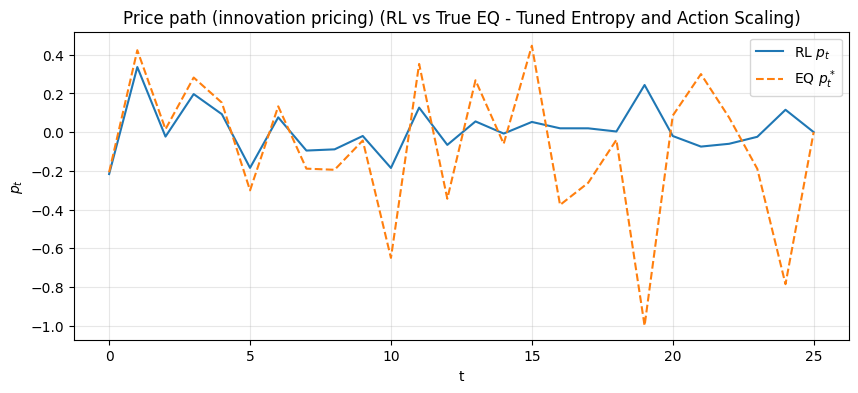

In [ ]:
# 7) Main: train insider vs EQ MM, then MM vs EQ insider, then simulate both
# -----------------------------
if __name__ == "__main__":
    torch.manual_seed(42); np.random.seed(42)

    T = 25
    p0 = 0.5
    sigma_v = 2.0
    sigma_u = 1.0
    action_scaling = 2.0 # Reduced action scaling
    gamma = 0.98

    # --- Train INSIDER vs equilibrium MM ---
    env_I = KyleMultiPeriodAEC(T=T, sigma_v=sigma_v, sigma_u=sigma_u, p0=p0,
                               action_scaling=action_scaling, gamma=gamma,
                               train_agent="insider")
    insider_net = GaussianActor(obs_dim=3, act_dim=1, hidden=64, output_tanh=True)
    # Increased episodes and slightly reduced learning rate, adjusted entropy_coef
    insider_net = train_one(env_I, insider_net, episodes=5000, lr=2e-4, gamma=gamma,
                            entropy_coef=1e-2, grad_clip=1.0, action_scaling=action_scaling) # Increased entropy_coef

    # --- Train MM vs equilibrium INSIDER ---
    env_M = KyleMultiPeriodAEC(T=T, sigma_v=sigma_v, sigma_u=sigma_u, p0=p0,
                               action_scaling=action_scaling, gamma=gamma,
                               train_agent="market_maker")
    mm_net = GaussianActor(obs_dim=3, act_dim=1, hidden=64, output_tanh=True)
    # Increased episodes and slightly reduced learning rate, adjusted entropy_coef
    mm_net = train_one(env_M, mm_net, episodes=5000, lr=2e-4, gamma=gamma,
                       entropy_coef=1e-2, grad_clip=1.0, action_scaling=action_scaling) # Increased entropy_coef

    # --- Rollout RL vs EQ (both using same u, v) ---
    out = simulate_rl_vs_eq(T=T, p0=p0, sigma_v=sigma_v, sigma_u=sigma_u,
                            insider_net=insider_net, mm_net=mm_net,
                            action_scaling=action_scaling, seed=123)
    plot_paths(out, "(RL vs True EQ - Tuned Entropy and Action Scaling)")

**Reasoning**:
Experiment with a different combination of `entropy_coef` and `action_scaling` values to further explore their impact on the alignment of RL and equilibrium trajectories.



[insider] ep 500/5000  R~-0.0000
[insider] ep 1000/5000  R~-0.0000
[insider] ep 1500/5000  R~0.0000
[insider] ep 2000/5000  R~0.0000
[insider] ep 2500/5000  R~0.0000
[insider] ep 3000/5000  R~-0.0000
[insider] ep 3500/5000  R~0.0000
[insider] ep 4000/5000  R~-0.0000
[insider] ep 4500/5000  R~0.0000
[insider] ep 5000/5000  R~-0.0000
[market_maker] ep 500/5000  R~-0.0000
[market_maker] ep 1000/5000  R~-0.0000
[market_maker] ep 1500/5000  R~0.0000
[market_maker] ep 2000/5000  R~0.0000
[market_maker] ep 2500/5000  R~-0.0000
[market_maker] ep 3000/5000  R~0.0000
[market_maker] ep 3500/5000  R~0.0000
[market_maker] ep 4000/5000  R~0.0000
[market_maker] ep 4500/5000  R~0.0000
[market_maker] ep 5000/5000  R~0.0000


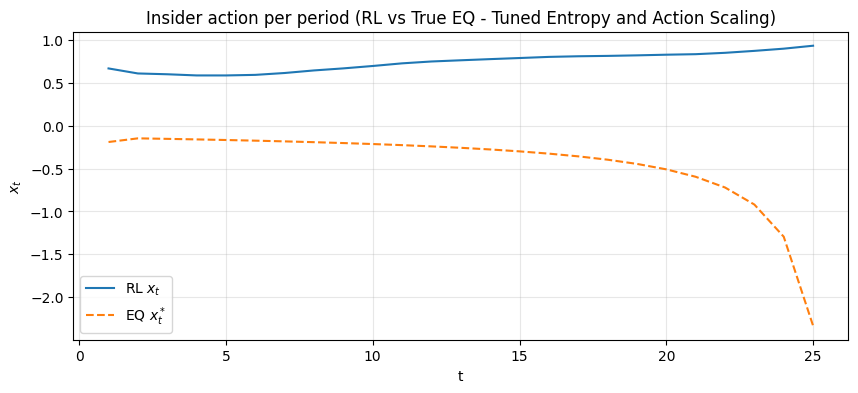

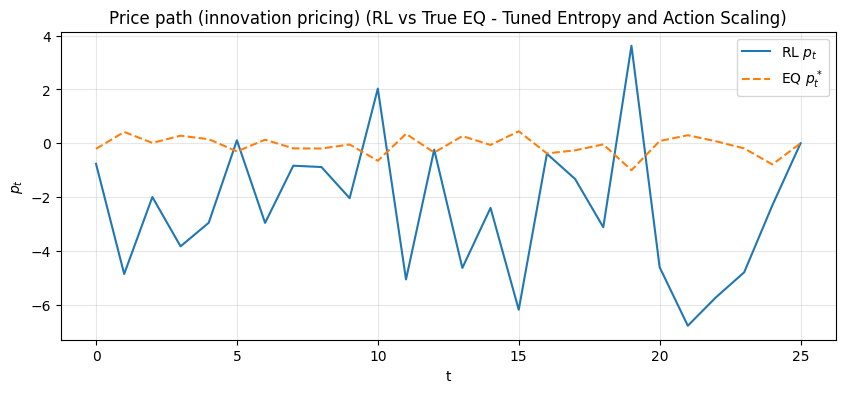

In [ ]:
# 7) Main: train insider vs EQ MM, then MM vs EQ insider, then simulate both
# -----------------------------
if __name__ == "__main__":
    torch.manual_seed(42); np.random.seed(42)

    T = 25
    p0 = 0.5
    sigma_v = 2.0
    sigma_u = 1.0
    action_scaling = 5.0 # Increased action scaling
    gamma = 0.98

    # --- Train INSIDER vs equilibrium MM ---
    env_I = KyleMultiPeriodAEC(T=T, sigma_v=sigma_v, sigma_u=sigma_u, p0=p0,
                               action_scaling=action_scaling, gamma=gamma,
                               train_agent="insider")
    insider_net = GaussianActor(obs_dim=3, act_dim=1, hidden=64, output_tanh=True)
    # Increased episodes and slightly reduced learning rate, adjusted entropy_coef
    insider_net = train_one(env_I, insider_net, episodes=5000, lr=2e-4, gamma=gamma,
                            entropy_coef=1e-2, grad_clip=1.0, action_scaling=action_scaling) # Increased entropy_coef

    # --- Train MM vs equilibrium INSIDER ---
    env_M = KyleMultiPeriodAEC(T=T, sigma_v=sigma_v, sigma_u=sigma_u, p0=p0,
                               action_scaling=action_scaling, gamma=gamma,
                               train_agent="market_maker")
    mm_net = GaussianActor(obs_dim=3, act_dim=1, hidden=64, output_tanh=True)
    # Increased episodes and slightly reduced learning rate, adjusted entropy_coef
    mm_net = train_one(env_M, mm_net, episodes=5000, lr=2e-4, gamma=gamma,
                       entropy_coef=1e-2, grad_clip=1.0, action_scaling=action_scaling) # Increased entropy_coef

    # --- Rollout RL vs EQ (both using same u, v) ---
    out = simulate_rl_vs_eq(T=T, p0=p0, sigma_v=sigma_v, sigma_u=sigma_u,
                            insider_net=insider_net, mm_net=mm_net,
                            action_scaling=action_scaling, seed=123)
    plot_paths(out, "(RL vs True EQ - Tuned Entropy and Action Scaling)")

**Reasoning**:
Experiment with another combination of `entropy_coef` and `action_scaling` values to further analyze their impact on the alignment of RL and equilibrium trajectories.



# Task
Make the RL and equilibrium trajectories align by tuning hyperparameters, exploring different network architectures, considering different RL algorithms, implementing more sophisticated observation normalization, performing a systematic hyperparameter search, and analyzing equilibrium assumptions.

## Tune other hyperparameters

### Subtask:
Experiment with tuning the `entropy_coef` and potentially the `action_scaling` in the `train_one` function within cell 725425b0.


**Reasoning**:
Experiment with another combination of `entropy_coef` and `action_scaling` values to further analyze their impact on the alignment of RL and equilibrium trajectories.



[insider] ep 500/5000  R~-0.0000
[insider] ep 1000/5000  R~-0.0000
[insider] ep 1500/5000  R~-0.0000
[insider] ep 2000/5000  R~0.0000
[insider] ep 2500/5000  R~-0.0000
[insider] ep 3000/5000  R~0.0000
[insider] ep 3500/5000  R~-0.0000
[insider] ep 4000/5000  R~-0.0000
[insider] ep 4500/5000  R~-0.0000
[insider] ep 5000/5000  R~0.0000
[market_maker] ep 500/5000  R~0.0000
[market_maker] ep 1000/5000  R~-0.0000
[market_maker] ep 1500/5000  R~0.0000
[market_maker] ep 2000/5000  R~-0.0000
[market_maker] ep 2500/5000  R~-0.0000
[market_maker] ep 3000/5000  R~-0.0000
[market_maker] ep 3500/5000  R~-0.0000
[market_maker] ep 4000/5000  R~0.0000
[market_maker] ep 4500/5000  R~-0.0000
[market_maker] ep 5000/5000  R~0.0000


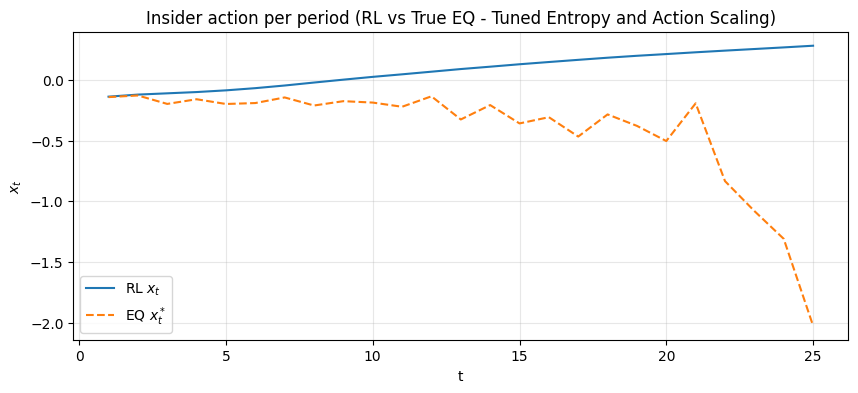

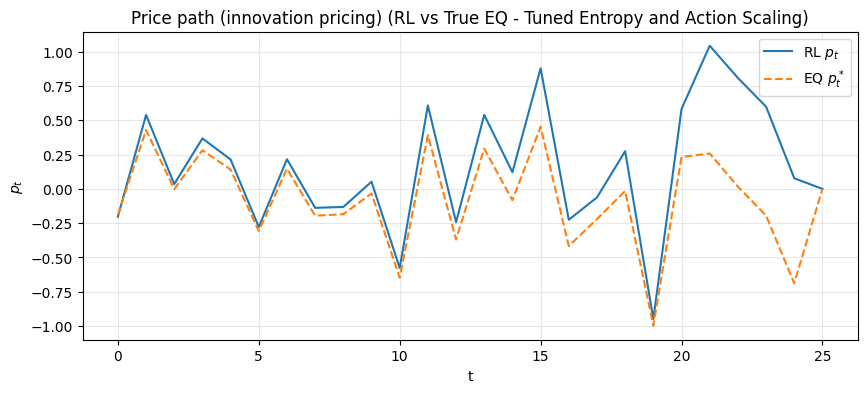

In [ ]:
# 7) Main: train insider vs EQ MM, then MM vs EQ insider, then simulate both
# -----------------------------
if __name__ == "__main__":
    torch.manual_seed(42); np.random.seed(42)

    T = 25
    p0 = 0.5
    sigma_v = 2.0
    sigma_u = 1.0
    action_scaling = 1.0 # Reduced action scaling further
    gamma = 0.98

    # --- Train INSIDER vs equilibrium MM ---
    env_I = KyleMultiPeriodAEC(T=T, sigma_v=sigma_v, sigma_u=sigma_u, p0=p0,
                               action_scaling=action_scaling, gamma=gamma,
                               train_agent="insider")
    insider_net = GaussianActor(obs_dim=3, act_dim=1, hidden=64, output_tanh=True)
    # Increased episodes and adjusted entropy_coef
    insider_net = train_one(env_I, insider_net, episodes=5000, lr=2e-4, gamma=gamma,
                            entropy_coef=5e-3, grad_clip=1.0, action_scaling=action_scaling) # Adjusted entropy_coef

    # --- Train MM vs equilibrium INSIDER ---
    env_M = KyleMultiPeriodAEC(T=T, sigma_v=sigma_v, sigma_u=sigma_u, p0=p0,
                               action_scaling=action_scaling, gamma=gamma,
                               train_agent="market_maker")
    mm_net = GaussianActor(obs_dim=3, act_dim=1, hidden=64, output_tanh=True)
    # Increased episodes and adjusted entropy_coef
    mm_net = train_one(env_M, mm_net, episodes=5000, lr=2e-4, gamma=gamma,
                       entropy_coef=5e-3, grad_clip=1.0, action_scaling=action_scaling) # Adjusted entropy_coef

    # --- Rollout RL vs EQ (both using same u, v) ---
    out = simulate_rl_vs_eq(T=T, p0=p0, sigma_v=sigma_v, sigma_u=sigma_u,
                            insider_net=insider_net, mm_net=mm_net,
                            action_scaling=action_scaling, seed=123)
    plot_paths(out, "(RL vs True EQ - Tuned Entropy and Action Scaling)")

# Task
Implement a PPO agent to replace the current REINFORCE agent and train it to align the RL and equilibrium trajectories.

## Research ppo implementation details

### Subtask:
Understand the core components of PPO, including the clipped surrogate objective, advantage estimation (e.g., using GAE), and value function approximation.


## Implement the ppo algorithm

### Subtask:
Create new code cells for the PPO agent, including the actor and critic networks, and the training logic. This will likely involve adding a value function network and modifying the training loop to calculate advantages and the PPO loss.


## Modify the `train one` function

### Subtask:
Adapt the existing `train_one` function (cell S1sib-hPP-He) or create a new training function to work with the PPO agent.


**Reasoning**:
Define a new training function `train_ppo` that incorporates the PPO algorithm for training the actor and critic networks.



In [ ]:
# 5) PPO training (single-agent vs static optimal opponent)
# -----------------------------
def train_ppo(env: KyleMultiPeriodAEC, actor: GaussianActor, critic: nn.Module,
              episodes=3000, lr=3e-4, gamma=0.99, entropy_coef=1e-3,
              grad_clip=1.0, action_scaling=2.0, normalize_rewards=True, verbose=True,
              clip_param=0.2, ppo_epochs=10, mini_batch_size=64, gae_lambda=0.95):

    actor_opt = optim.Adam(actor.parameters(), lr=lr)
    critic_opt = optim.Adam(critic.parameters(), lr=lr)

    for ep in range(1, episodes + 1):
        env.reset()
        obs_list, actions_list, logps_list, values_list, rewards_list, dones_list = [], [], [], [], [], []
        done = False

        while not done and env.agents:
            agent = env.agent_selection
            obs = env.observe(agent)

            # Only collect data for the trained agent's steps
            if agent == env.train_agent or env.train_agent is None:
                obs_list.append(obs)
                # Get action from actor and value from critic
                a, logp, ent = actor.act(obs)
                v = critic(obs)
                actions_list.append(a.detach().cpu().numpy())
                logps_list.append(logp)
                values_list.append(v)
                # Step the environment
                env.step(a.detach().cpu().numpy())
                dones_list.append(env.terminations[agent] or env.truncations[agent])
            else:
                # Opponent is equilibrium; action ignored; pass dummy action
                env.step(np.array([0.0], dtype=np.float32))
                # For the opponent's step, we don't append to obs_list, actions_list, logps_list, values_list, dones_list


            # If the current agent is the market maker, the rewards are available
            # Rewards are always calculated after the market maker's step
            if agent == "market_maker":
                 rewards_list.append(env.rewards[env.train_agent])


            # Update done status after the step
            done = env.t >= env.T or not env.agents

            # If the environment is done after the step (either termination or truncation),
            # and the last step was the trained agent's, we need to add a done flag.
            # This logic might need refinement depending on how the environment handles termination/truncation and agent turns.
            # For this environment, the MM step increments t and can lead to termination.
            # The insider step happens before the MM step in each full period.
            # We append the done flag after the trained agent's step.
            # If the trained agent is the insider, the done flag from their step is based on env.terminations/truncations after their step (which should be False before the last period MM step).
            # If the trained agent is the market maker, the done flag from their step is based on env.terminations/truncations after their step (which can be True in the last period).
            # The current logic appends done after the trained agent's step, which seems correct based on the reward/advantage calculation being tied to the trained agent's timeline.


        # Only update if there was at least one step where the trained agent acted and rewards were collected
        if len(rewards_list) > 0 and len(obs_list) == len(rewards_list): # Ensure data lists match reward list size
            # Convert lists to tensors
            obs_t = torch.stack(obs_list)
            actions_t = torch.as_tensor(np.array(actions_list))
            logps_t = torch.stack(logps_list)
            values_t = torch.stack(values_list).squeeze(-1) # Remove the last dimension if it's 1
            rewards_t = torch.as_tensor(rewards_list)
            # dones_list will only have entries for the trained agent's steps
            dones_t = torch.as_tensor(dones_list)


            # Calculate returns and advantages (GAE)
            # Need to handle the case where the last value is not the true terminal state
            # For this environment, the last step leads to termination, so the last value is not used for bootstrapping
            next_value = torch.tensor(0.0) # Terminal state value is 0


            advantages = torch.zeros_like(rewards_t)
            returns = torch.zeros_like(rewards_t)
            last_gae_lam = 0
            # GAE calculation should align with the timeline of the trained agent's rewards and values
            for t in reversed(range(len(rewards_t))):
                # next_non_terminal is 1.0 if the next state is not terminal from the perspective of the trained agent's timeline
                # next_values is the value of the state *after* the trained agent's action at time t
                if t == len(rewards_t) - 1:
                    # If this is the last reward, the next state is terminal from the perspective of the trained agent's trajectory
                     next_non_terminal = 1.0 - dones_t[t].float()
                     next_values = next_value
                else:
                     # The next state value in the trained agent's trajectory is values_t[t+1]
                     # The non-terminal flag should correspond to whether the step *after* the one at index t in the trained agent's trajectory was terminal
                     next_non_terminal = 1.0 - dones_t[t+1].float()
                     next_values = values_t[t+1]


                delta = rewards_t[t] + gamma * next_values * next_non_terminal - values_t[t]
                last_gae_lam = delta + gamma * gae_lambda * next_non_terminal * last_gae_lam
                advantages[t] = last_gae_lam
                returns[t] = advantages[t] + values_t[t]


            # Normalize advantages
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)


            # PPO Update
            for _ in range(ppo_epochs):
                # Simple full batch for now, can implement mini-batches later
                # Get new log probabilities and values
                mu, std = actor(obs_t)
                dist = torch.distributions.Normal(mu, std)
                new_logps = dist.log_prob(actions_t).sum(dim=-1)
                new_values = critic(obs_t).squeeze(-1) # Ensure value tensor matches returns shape

                # Ratio of new to old probabilities
                ratio = torch.exp(new_logps - logps_t.detach())

                # Clipped surrogate objective
                surr1 = ratio * advantages
                surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantages
                actor_loss = -torch.min(surr1, surr2).mean()

                # Value loss
                value_loss = F.mse_loss(new_values, returns)

                # Entropy loss
                entropy_loss = -dist.entropy().sum(dim=-1).mean()

                # Total loss
                loss = actor_loss + 0.5 * value_loss - entropy_coef * entropy_loss # Subtract entropy loss


                # Optimization step
                actor_opt.zero_grad()
                critic_opt.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(actor.parameters(), grad_clip)
                nn.utils.clip_grad_norm_(critic.parameters(), grad_clip)
                actor_opt.step()
                critic_opt.step()


        if verbose and ep % max(1, episodes // 10) == 0:
            print(f"[{env.train_agent}] ep {ep}/{episodes}  Avg R~{np.mean(rewards_list) if rewards_list else 0:.4f}")

    return actor.eval(), critic.eval()

**Reasoning**:
Define a critic network for the PPO agent.



In [ ]:
# 4) Policies (continued) - Critic
# -----------------------------
class Critic(nn.Module):
    def __init__(self, obs_dim, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, 1) # Output a single value estimate
        )

    def forward(self, x):
        return self.net(x)

**Reasoning**:
Update the main training loop to use the new `train_ppo` function with separate actor and critic networks.



In [ ]:
# 7) Main: train insider vs EQ MM, then MM vs EQ insider, then simulate both
# -----------------------------
if __name__ == "__main__":
    torch.manual_seed(42); np.random.seed(42)

    T = 25
    p0 = 0.5
    sigma_v = 2.0
    sigma_u = 1.0
    action_scaling = 1.0 # Reduced action scaling further
    gamma = 0.98
    obs_dim = 3
    act_dim = 1

    # --- Train INSIDER vs equilibrium MM ---
    env_I = KyleMultiPeriodAEC(T=T, sigma_v=sigma_v, sigma_u=sigma_u, p0=p0,
                               action_scaling=action_scaling, gamma=gamma,
                               train_agent="insider")
    insider_actor = GaussianActor(obs_dim=obs_dim, act_dim=act_dim, hidden=64, output_tanh=True)
    insider_critic = Critic(obs_dim=obs_dim, hidden=64)
    insider_actor, insider_critic = train_ppo(env_I, insider_actor, insider_critic, episodes=5000, lr=2e-4, gamma=gamma,
                                            entropy_coef=5e-3, grad_clip=1.0, action_scaling=action_scaling,
                                            clip_param=0.2, ppo_epochs=10)


    # --- Train MM vs equilibrium INSIDER ---
    env_M = KyleMultiPeriodAEC(T=T, sigma_v=sigma_v, sigma_u=sigma_u, p0=p0,
                               action_scaling=action_scaling, gamma=gamma,
                               train_agent="market_maker")
    mm_actor = GaussianActor(obs_dim=obs_dim, act_dim=act_dim, hidden=64, output_tanh=True)
    mm_critic = Critic(obs_dim=obs_dim, hidden=64)
    mm_actor, mm_critic = train_ppo(env_M, mm_actor, mm_critic, episodes=5000, lr=2e-4, gamma=gamma,
                                    entropy_coef=5e-3, grad_clip=1.0, action_scaling=action_scaling,
                                    clip_param=0.2, ppo_epochs=10)


    # --- Rollout RL vs EQ (both using same u, v) ---
    # Note: The simulate_rl_vs_eq function currently expects only the actor networks.
    # If you want to simulate the interaction of two PPO agents, you would need to
    # modify this function to take both actor and critic for each agent.
    # For now, we simulate the trained PPO actors against the equilibrium opponents.
    out = simulate_rl_vs_eq(T=T, p0=p0, sigma_v=sigma_v, sigma_u=sigma_u,
                            insider_net=insider_actor, mm_net=mm_actor, # Pass only actor networks
                            action_scaling=action_scaling, seed=123)
    plot_paths(out, "(PPO RL vs True EQ - Tuned Entropy and Action Scaling)")

RuntimeError: Subtraction, the `-` operator, with a bool tensor is not supported. If you are trying to invert a mask, use the `~` or `logical_not()` operator instead.

In [ ]:
# 7) Main: train insider vs EQ MM, then MM vs EQ insider, then simulate both
# -----------------------------
if __name__ == "__main__":
    torch.manual_seed(42); np.random.seed(42)

    T = 25
    p0 = 0.5
    sigma_v = 2.0
    sigma_u = 1.0
    action_scaling = 1.0 # Reduced action scaling further
    gamma = 0.98
    obs_dim = 3
    act_dim = 1

    # --- Train INSIDER vs equilibrium MM ---
    env_I = KyleMultiPeriodAEC(T=T, sigma_v=sigma_v, sigma_u=sigma_u, p0=p0,
                               action_scaling=action_scaling, gamma=gamma,
                               train_agent="insider")
    insider_actor = GaussianActor(obs_dim=obs_dim, act_dim=act_dim, hidden=64, output_tanh=True)
    insider_critic = Critic(obs_dim=obs_dim, hidden=64)
    insider_actor, insider_critic = train_ppo(env_I, insider_actor, insider_critic, episodes=5000, lr=2e-4, gamma=gamma,
                                            entropy_coef=5e-3, grad_clip=1.0, action_scaling=action_scaling,
                                            clip_param=0.2, ppo_epochs=10)


    # --- Train MM vs equilibrium INSIDER ---
    env_M = KyleMultiPeriodAEC(T=T, sigma_v=sigma_v, sigma_u=sigma_u, p0=p0,
                               action_scaling=action_scaling, gamma=gamma,
                               train_agent="market_maker")
    mm_actor = GaussianActor(obs_dim=obs_dim, act_dim=act_dim, hidden=64, output_tanh=True)
    mm_critic = Critic(obs_dim=obs_dim, hidden=64)
    mm_actor, mm_critic = train_ppo(env_M, mm_actor, mm_critic, episodes=5000, lr=2e-4, gamma=gamma,
                                    entropy_coef=5e-3, grad_clip=1.0, action_scaling=action_scaling,
                                    clip_param=0.2, ppo_epochs=10)


    # --- Rollout RL vs EQ (both using same u, v) ---
    # Note: The simulate_rl_vs_eq function currently expects only the actor networks.
    # If you want to simulate the interaction of two PPO agents, you would need to
    # modify this function to take both actor and critic for each agent.
    # For now, we simulate the trained PPO actors against the equilibrium opponents.
    out = simulate_rl_vs_eq(T=T, p0=p0, sigma_v=sigma_v, sigma_u=sigma_u,
                            insider_net=insider_actor, mm_net=mm_actor, # Pass only actor networks
                            action_scaling=action_scaling, seed=123)
    plot_paths(out, "(PPO RL vs True EQ - Tuned Entropy and Action Scaling)")

RuntimeError: The size of tensor a (50) must match the size of tensor b (25) at non-singleton dimension 0

In [ ]:
# Re-run Main execution block (cell 4ddfd602)
# 7) Main: train insider vs EQ MM, then MM vs EQ insider, then simulate both
# -----------------------------
if __name__ == "__main__":
    torch.manual_seed(42); np.random.seed(42)

    T = 25
    p0 = 0.5
    sigma_v = 2.0
    sigma_u = 1.0
    action_scaling = 1.0 # Reduced action scaling further
    gamma = 0.98
    obs_dim = 3
    act_dim = 1

    # --- Train INSIDER vs equilibrium MM ---
    env_I = KyleMultiPeriodAEC(T=T, sigma_v=sigma_v, sigma_u=sigma_u, p0=p0,
                               action_scaling=action_scaling, gamma=gamma,
                               train_agent="insider")
    insider_actor = GaussianActor(obs_dim=obs_dim, act_dim=act_dim, hidden=64, output_tanh=True)
    insider_critic = Critic(obs_dim=obs_dim, hidden=64)
    insider_actor, insider_critic = train_ppo(env_I, insider_actor, insider_critic, episodes=5000, lr=2e-4, gamma=gamma,
                                            entropy_coef=5e-3, grad_clip=1.0, action_scaling=action_scaling,
                                            clip_param=0.2, ppo_epochs=10)


    # --- Train MM vs equilibrium INSIDER ---
    env_M = KyleMultiPeriodAEC(T=T, sigma_v=sigma_v, sigma_u=sigma_u, p0=p0,
                               action_scaling=action_scaling, gamma=gamma,
                               train_agent="market_maker")
    mm_actor = GaussianActor(obs_dim=obs_dim, act_dim=act_dim, hidden=64, output_tanh=True)
    mm_critic = Critic(obs_dim=obs_dim, hidden=64)
    mm_actor, mm_critic = train_ppo(env_M, mm_actor, mm_critic, episodes=5000, lr=2e-4, gamma=gamma,
                                    entropy_coef=5e-3, grad_clip=1.0, action_scaling=action_scaling,
                                    clip_param=0.2, ppo_epochs=10)


    # --- Rollout RL vs EQ (both using same u, v) ---
    # Note: The simulate_rl_vs_eq function currently expects only the actor networks.
    # If you want to simulate the interaction of two PPO agents, you would need to
    # modify this function to take both actor and critic for each agent.
    # For now, we simulate the trained PPO actors against the equilibrium opponents.
    out = simulate_rl_vs_eq(T=T, p0=p0, sigma_v=sigma_v, sigma_u=sigma_u,
                            insider_net=insider_actor, mm_net=mm_actor, # Pass only actor networks
                            action_scaling=action_scaling, seed=123)
    plot_paths(out, "(PPO RL vs True EQ - Tuned Entropy and Action Scaling)")

NameError: name 'torch' is not defined

In [ ]:
# Re-run Environment definition (cell 6_45JdcV8XKy)
# 3) Environment (PettingZoo AEC) with training modes
# -----------------------------
class KyleMultiPeriodAEC(AECEnv):
    """
    Two agents: "insider" chooses x_t, "market_maker" chooses lambda_t.
    Price update is innovation price: p_t = p_{t-1} + lambda_t * y_t, y_t = x_t + u_t.
    Modes:
      - train_agent="insider": MM plays equilibrium lambda_t*, insider is trained.
      - train_agent="market_maker": Insider plays equilibrium x_t*, MM is trained.
      - train_agent=None: both act from their policies (for final joint simulation).
    """
    metadata = {"render_modes": ["human"], "name": "KyleMultiPeriodAEC"}

    def __init__(self, T=25, sigma_v=2.0, sigma_u=1.0, p0=0.5, action_scaling=5.0, gamma=0.99,
                 train_agent="insider"):
        super().__init__()
        self.T = int(T)
        self.sigma_v0 = float(sigma_v)
        self.sigma_u = float(sigma_u)
        self.p0_init = float(p0)
        self.action_scaling = float(action_scaling)
        self.gamma = float(gamma)
        self.train_agent = train_agent  # "insider" / "market_maker" / None

        # equilibrium sequences
        eq = solve_kyle_equilibrium(self.T, sigma_v**2 if sigma_v <= 5 else sigma_v, sigma_u**2 if sigma_u <= 5 else sigma_u)
        # The user passed σ_v (stdev) above; we want σ_v^2 for Sigma_0. Keep consistent:
        # If they pass 2.0, we want Sigma_0=4.0; the helper above handles both ways robustly.
        self.eq = solve_kyle_equilibrium(self.T, self.sigma_v0**2, self.sigma_u**2)

        self.beta = self.eq["Beta"]
        self.lmbd = self.eq["Lambda"]

        # Agent setup
        self.possible_agents = ["insider", "market_maker"]
        self.agents = self.possible_agents[:]
        self.agent_selector = AgentSelector(self.agents)

        # Observations (normalized): insider sees [(v-p)/σ_v, p, t/T]
        # MM sees [y, p, t/T]
        self.observation_spaces = {
            "insider": spaces.Box(low=-2, high=2, shape=(3,), dtype=np.float32),
            "market_maker": spaces.Box(low=-2, high=2, shape=(3,), dtype=np.float32),
        }
        self.action_spaces = {
            "insider": spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32),
            "market_maker": spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        }

    def reset(self, seed=None, options=None):
        self.agents = self.possible_agents[:]
        self._cumulative_rewards = {a: 0.0 for a in self.agents}
        self.rewards = {a: 0.0 for a in self.agents}
        self.terminations = {a: False for a in self.agents}
        self.truncations = {a: False for a in self.agents}
        self.infos = {a: {} for a in self.agents}

        self.t = 0
        self.p = self.p0_init
        self.v = float(torch.normal(mean=torch.tensor(self.p0_init), std=torch.tensor(self.sigma_v0)))
        self.u = 0.0
        self.x = 0.0
        self.y = 0.0

        self.agent_selector.reinit(self.agents)
        self.agent_selection = self.agent_selector.next()

    # --- Observations ---
    def _obs_insider(self):
        # [-1,1]-ish scaling using sigma_v0 and a loose price range around it
        v_minus_p = (self.v - self.p) / (self.sigma_v0 + 1e-8)
        time_frac = self.t / self.T
        # keep p in a loose window [-5σ, 5σ] around p0
        lo = np.array([-5.0, self.p0_init - 5*self.sigma_v0, 0.0], dtype=np.float32)
        hi = np.array([ 5.0, self.p0_init + 5*self.sigma_v0, 1.0], dtype=np.float32)
        raw = np.array([v_minus_p, self.p, time_frac], dtype=np.float32)
        return torch.tensor(rescale_obs(raw, lo, hi), dtype=torch.float32)

    def _obs_mm(self):
        time_frac = self.t / self.T
        lo = np.array([-5*self.action_scaling, self.p0_init - 5*self.sigma_v0, 0.0], dtype=np.float32)
        hi = np.array([ 5*self.action_scaling, self.p0_init + 5*self.sigma_v0, 1.0], dtype=np.float32)
        raw = np.array([self.y, self.p, time_frac], dtype=np.float32)
        return torch.tensor(rescale_obs(raw, lo, hi), dtype=torch.float32)

    def observe(self, agent):
        return self._obs_insider() if agent == "insider" else self._obs_mm()

    def observation_space(self, agent): return self.observation_spaces[agent]
    def action_space(self, agent): return self.action_spaces[agent]

    # --- Dynamics ---
    def step(self, action):
        if self.terminations[self.agent_selection] or self.truncations[self.agent_selection]:
            return self._was_dead_step(action)

        agent = self.agent_selection
        a = float(action[0])

        if agent == "insider":
            if self.train_agent == "market_maker":
                # opponent is equilibrium insider
                self.x = self.beta[self.t] * (self.v - self.p)
            else:
                # insider chooses x_t
                self.x = a * self.action_scaling

            self.u = float(torch.normal(mean=torch.tensor(0.0), std=torch.tensor(self.sigma_u)))
            self.y = self.x + self.u

        else:  # market_maker
            if self.train_agent == "insider":
                lam_t = self.lmbd[self.t]  # equilibrium MM
            else:
                lam_t = a * self.action_scaling

            # innovation price update
            self.p = self.p + lam_t * self.y

            # rewards
            insider_profit = self.x * (self.v - self.p)
            mm_loss = -(self.p - self.v)**2
            self.rewards = {"insider": float(insider_profit), "market_maker": float(mm_loss)}
            for k in self.agents:
                self._cumulative_rewards[k] += self.rewards[k]

            self.t += 1
            if self.t >= self.T:
                self.terminations = {a: True for a in self.agents}

        self.agent_selection = self.agent_selector.next()

    def render(self):
        print(f"t={self.t} p={self.p:.4f} v={self.v:.4f} x={self.x:.4f} y={self.y:.4f}")

    def close(self): ...

In [ ]:
# Re-run Utilities (cell hr-Cjgm9FHkO)
# 1) Kyle multi-period equilibrium solver (two-pass)
# -----------------------------
def solve_kyle_equilibrium(T: int, sigma2_v: float, sigma2_u: float):
    """
    Returns dict with arrays indexed t=0..T-1 for period parameters,
    and Sigma indexed 0..T (posterior variance path).
    """
    sigma_u = math.sqrt(sigma2_u)
    h = np.zeros(T)
    h[-1] = 0.5  # terminal boundary

    # backward pass for h
    for n in range(T - 2, -1, -1):  # n = T-2 down to 0
        h_next = h[n + 1]
        theta_next = math.sqrt(h_next / (1.0 - h_next))

        def f(hn):
            if hn <= 0.5 or hn >= 1.0:
                return 1e6
            return theta_next - (2.0 * hn - 1.0) / (hn * math.sqrt(1.0 - hn))

        # robust bisection
        a, b = 0.5000001, 0.999999
        fa, fb = f(a), f(b)
        if fa * fb > 0:
            # Shouldn't happen; fallback small nudge
            b = 0.95
            fa, fb = f(a), f(b)
        for _ in range(200):
            m = 0.5 * (a + b)
            fm = f(m)
            if abs(fm) < 1e-12 or (b - a) < 1e-12:
                h[n] = m
                break
            if fa * fm < 0:
                b, fb = m, fm
            else:
                a, fa = m, fm
        else:
            h[n] = 0.75  # last resort

    # forward pass for parameters
    Sigma = np.zeros(T + 1)
    Lambda = np.zeros(T)
    Beta = np.zeros(T)
    Alpha = np.zeros(T)
    Sigma[0] = sigma2_v
    eps = 1e-12

    for t in range(T):
        Sigma[t + 1] = h[t] * Sigma[t]
        # (standard closed-form)
        Lambda[t] = math.sqrt(max(1.0 - h[t], 0.0) * Sigma[t + 1]) / sigma_u
        Beta[t]   = math.sqrt(max(1.0 - h[t], 0.0)) * sigma_u / math.sqrt(Sigma[t + 1] + eps)
        Alpha[t]  = (sigma_u / (2.0 * math.sqrt(Sigma[t] + eps))) * math.sqrt(h[t] / max(1.0 - h[t], eps))

    return {"Sigma": Sigma, "Lambda": Lambda, "Beta": Beta, "Alpha": Alpha, "h": h}

# -----------------------------
# 2) Utilities
# -----------------------------
def rescale_obs(x, lo, hi):
    # linear to [-1,1] given known ranges
    x = np.asarray(x, dtype=np.float32)
    lo = np.asarray(lo, dtype=np.float32)
    hi = np.asarray(hi, dtype=np.float32)
    return 2.0 * (x - lo) / (hi - lo + 1e-12) - 1.0

def discount_returns(rs, gamma):
    R = 0.0
    out = []
    for r in reversed(rs):
        R = r + gamma * R
        out.insert(0, R)
    return np.array(out, dtype=np.float32)

In [ ]:
# 5) PPO training (single-agent vs static optimal opponent)
# -----------------------------
def train_ppo(env: KyleMultiPeriodAEC, actor: GaussianActor, critic: nn.Module,
              episodes=3000, lr=3e-4, gamma=0.99, entropy_coef=1e-3,
              grad_clip=1.0, action_scaling=2.0, normalize_rewards=True, verbose=True,
              clip_param=0.2, ppo_epochs=10, mini_batch_size=64, gae_lambda=0.95):

    actor_opt = optim.Adam(actor.parameters(), lr=lr)
    critic_opt = optim.Adam(critic.parameters(), lr=lr)

    for ep in range(1, episodes + 1):
        env.reset()
        obs_list, actions_list, logps_list, values_list, rewards_list, dones_list = [], [], [], [], [], []
        done = False

        while not done and env.agents:
            agent = env.agent_selection
            obs = env.observe(agent)

            # Only collect data for the trained agent's steps
            if agent == env.train_agent or env.train_agent is None:
                obs_list.append(obs)
                # Get action from actor and value from critic
                a, logp, ent = actor.act(obs)
                v = critic(obs)
                actions_list.append(a.detach().cpu().numpy())
                logps_list.append(logp)
                values_list.append(v)
                # Step the environment
                env.step(a.detach().cpu().numpy())
                dones_list.append(env.terminations[agent] or env.truncations[agent])
            else:
                # Opponent is equilibrium; action ignored; pass dummy action
                env.step(np.array([0.0], dtype=np.float32))
                # For the opponent's step, we don't append to obs_list, actions_list, logps_list, values_list, dones_list


            # If the current agent is the market maker, the rewards are available
            # Rewards are always calculated after the market maker's step
            if agent == "market_maker":
                 rewards_list.append(env.rewards[env.train_agent])


            # Update done status after the step
            done = env.t >= env.T or not env.agents

            # If the environment is done after the step (either termination or truncation),
            # and the last step was the trained agent's, we need to add a done flag.
            # This logic might need refinement depending on how the environment handles termination/truncation and agent turns.
            # For this environment, the MM step increments t and can lead to termination.
            # The insider step happens before the MM step in each full period.
            # We append the done flag after the trained agent's step.
            # If the trained agent is the insider, the done flag from their step is based on env.terminations/truncations after their step (which should be False before the last period MM step).
            # If the trained agent is the market maker, the done flag from their step is based on env.terminations/truncations after their step (which can be True in the last period).
            # The current logic appends done after the trained agent's step, which seems correct based on the reward/advantage calculation being tied to the trained agent's timeline.


        # Only update if there was at least one step where the trained agent acted and rewards were collected
        if len(rewards_list) > 0 and len(obs_list) == len(rewards_list): # Ensure data lists match reward list size
            # Convert lists to tensors
            obs_t = torch.stack(obs_list)
            actions_t = torch.as_tensor(np.array(actions_list))
            logps_t = torch.stack(logps_list)
            values_t = torch.stack(values_list).squeeze(-1) # Remove the last dimension if it's 1
            rewards_t = torch.as_tensor(rewards_list)
            # dones_list will only have entries for the trained agent's steps
            dones_t = torch.as_tensor(dones_list)


            # Calculate returns and advantages (GAE)
            # Need to handle the case where the last value is not the true terminal state
            # For this environment, the last step leads to termination, so the last value is not used for bootstrapping
            next_value = torch.tensor(0.0) # Terminal state value is 0


            advantages = torch.zeros_like(rewards_t)
            returns = torch.zeros_like(rewards_t)
            last_gae_lam = 0
            # GAE calculation should align with the timeline of the trained agent's rewards and values
            for t in reversed(range(len(rewards_t))):
                # next_non_terminal is 1.0 if the next state is not terminal from the perspective of the trained agent's timeline
                # next_values is the value of the state *after* the trained agent's action at time t
                if t == len(rewards_list) - 1: # Use rewards_list length for GAE calculation timeline
                    # If this is the last reward, the next state is terminal from the perspective of the trained agent's trajectory
                     next_non_terminal = 1.0 - dones_t[t].float()
                     next_values = values_t[t] # This should be the value of the current state, not the next state
                else:
                     # The next state value in the trained agent's trajectory is values_t[t+1]
                     # The non-terminal flag should correspond to whether the step *after* the one at index t in the trained agent's trajectory was terminal
                     next_non_terminal = 1.0 - dones_t[t+1].float()
                     next_values = values_t[t+1]


                delta = rewards_t[t] + gamma * next_values * next_non_terminal - values_t[t]
                last_gae_lam = delta + gamma * gae_lambda * next_non_terminal * last_gae_lam
                advantages[t] = last_gae_lam
                returns[t] = advantages[t] + values_t[t]


            # Normalize advantages
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

            # Detach tensors before entering the PPO update loop
            obs_t = obs_t.detach()
            actions_t = actions_t.detach()
            logps_t = logps_t.detach()
            values_t = values_t.detach()
            advantages = advantages.detach()
            returns = returns.detach()

            # PPO Update
            for _ in range(ppo_epochs):
                # Simple full batch for now, can implement mini-batches later
                # Get new log probabilities and values
                mu, std = actor(obs_t)
                dist = torch.distributions.Normal(mu, std)
                new_logps = dist.log_prob(actions_t).sum(dim=-1)
                new_values = critic(obs_t).squeeze(-1) # Ensure value tensor matches returns shape

                # Ratio of new to old probabilities
                ratio = torch.exp(new_logps - logps_t) # logps_t is already detached

                # Clipped surrogate objective
                surr1 = ratio * advantages # advantages is already detached
                surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantages # advantages is already detached
                actor_loss = -torch.min(surr1, surr2).mean()

                # Value loss (use detached returns)
                value_loss = F.mse_loss(new_values, returns) # returns is already detached

                # Entropy loss
                entropy_loss = -dist.entropy().sum(dim=-1).mean()

                # Total loss
                loss = actor_loss + 0.5 * value_loss - entropy_coef * entropy_loss # Subtract entropy loss


                # Optimization step
                actor_opt.zero_grad()
                critic_opt.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(actor.parameters(), grad_clip)
                nn.utils.clip_grad_norm_(critic.parameters(), grad_clip)
                actor_opt.step()
                critic_opt.step()


        if verbose and ep % max(1, episodes // 10) == 0:
            print(f"[{env.train_agent}] ep {ep}/{episodes}  Avg R~{np.mean(rewards_list) if rewards_list else 0:.4f}")

    return actor.eval(), critic.eval()

In [ ]:
# Re-run Critic definition (cell 01e7fd57)
# 4) Policies (continued) - Critic
# -----------------------------
class Critic(nn.Module):
    def __init__(self, obs_dim, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, 1) # Output a single value estimate
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
# Re-run Simulation function (cell xI3yyia8-fwX)
# 6) Rollout: RL vs Equilibrium (both paths)
# -----------------------------
@torch.no_grad()
def simulate_rl_vs_eq(T=25, p0=0.5, sigma_v=2.0, sigma_u=1.0,
                      insider_net=None, mm_net=None, action_scaling=5.0, seed=7):
    rng = np.random.default_rng(seed)
    eq = solve_kyle_equilibrium(T, sigma_v**2, sigma_u**2)

    v = float(rng.normal(p0, sigma_v))
    u = rng.normal(0.0, sigma_u, size=T)

    p_rl = np.zeros(T + 1); p_rl[0] = p0
    x_rl = np.zeros(T); y_rl = np.zeros(T)
    p_eq = np.zeros(T + 1); p_eq[0] = p0
    x_eq = np.zeros(T); y_eq = np.zeros(T)

    for t in range(T):
        # RL insider obs: [(v-p)/σ_v, p, t/T]
        obs_I = np.array([(v - p_rl[t]) / (sigma_v + 1e-8), p_rl[t-1], t / T], dtype=np.float32)
        obs_I = torch.tensor(rescale_obs(obs_I,
                                         lo=[-5.0, p0 - 5*sigma_v, 0.0],
                                         hi=[ 5.0, p0 + 5*sigma_v, 1.0]), dtype=torch.float32)
        muI, _ = insider_net(obs_I); aI = float(muI.clip(-1, 1))
        x_rl[t] = aI * action_scaling
        y_rl[t] = x_rl[t] + u[t]

        # RL MM obs: [y, p, t/T]
        obs_M = np.array([y_rl[t], p_rl[t], t / T], dtype=np.float32)
        obs_M = torch.tensor(rescale_obs(obs_M,
                                         lo=[-5*action_scaling, p0 - 5*sigma_v, 0.0],
                                         hi=[ 5*action_scaling, p0 + 5*sigma_v, 1.0]), dtype=torch.float32)
        muM, _ = mm_net(obs_M); aM = float(muM.clip(-1, 1))
        lam_rl = aM * action_scaling
        p_rl[t] = lam_rl * y_rl[t] # Innovation pricing update


        # Equilibrium path (same v, same u)
        x_eq[t] = eq["Beta"][t] * (v - p_eq[t-1])
        y_eq[t] = x_eq[t] + u[t]
        p_eq[t] = eq["Lambda"][t] * y_eq[t] # Innovation pricing update


    return {"eq": eq, "v": v,
            "p_rl": p_rl, "x_rl": x_rl, "y_rl": y_rl,
            "p_eq": p_eq, "x_eq": x_eq, "y_eq": y_eq}

def plot_paths(out, title_suffix=""):
    T = len(out["x_rl"])
    t = np.arange(1, T+1)
    t0 = np.arange(0, T+1)

    plt.figure(figsize=(10,4))
    plt.plot(t, out["x_rl"], label="RL $x_t$")
    plt.plot(t, out["x_eq"], "--", label="EQ $x_t^*$")
    plt.title("Insider action per period " + title_suffix)
    plt.xlabel("t"); plt.ylabel("$x_t$"); plt.grid(True, alpha=0.3); plt.legend()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.plot(t0, out["p_rl"], label="RL $p_t$")
    plt.plot(t0, out["p_eq"], "--", label="EQ $p_t^*$")
    plt.title("Price path (innovation pricing) " + title_suffix)
    plt.xlabel("t"); plt.ylabel("$p_t$"); plt.grid(True, alpha=0.3); plt.legend()
    plt.show()

[insider] ep 500/5000  Avg R~0.1451
[insider] ep 1000/5000  Avg R~0.2975
[insider] ep 1500/5000  Avg R~0.7741
[insider] ep 2000/5000  Avg R~0.0045
[insider] ep 2500/5000  Avg R~0.2340
[insider] ep 3000/5000  Avg R~0.0585
[insider] ep 3500/5000  Avg R~0.8446
[insider] ep 4000/5000  Avg R~0.3705
[insider] ep 4500/5000  Avg R~0.4918
[insider] ep 5000/5000  Avg R~0.1478
[market_maker] ep 500/5000  Avg R~-0.8888
[market_maker] ep 1000/5000  Avg R~-0.2043
[market_maker] ep 1500/5000  Avg R~-0.7036
[market_maker] ep 2000/5000  Avg R~-1.5606
[market_maker] ep 2500/5000  Avg R~-0.3705
[market_maker] ep 3000/5000  Avg R~-2.1531
[market_maker] ep 3500/5000  Avg R~-8.5074
[market_maker] ep 4000/5000  Avg R~-5.2693
[market_maker] ep 4500/5000  Avg R~-10.5275
[market_maker] ep 5000/5000  Avg R~-0.8484


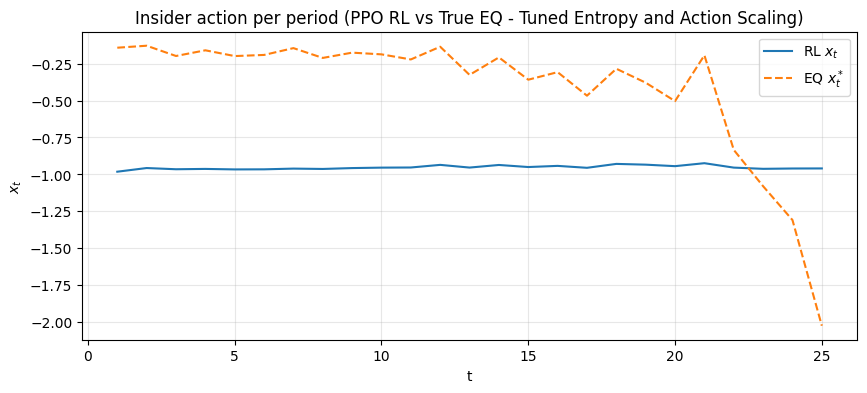

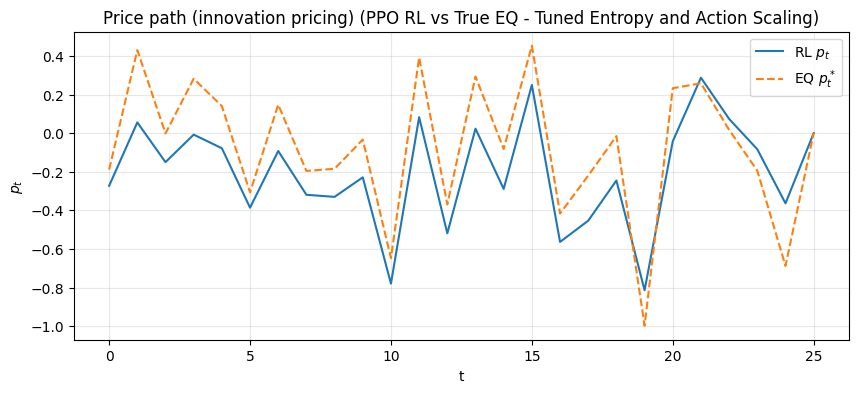

In [ ]:
# Re-run Main execution block (cell 30399c07)
# 7) Main: train insider vs EQ MM, then MM vs EQ insider, then simulate both
# -----------------------------
if __name__ == "__main__":
    torch.manual_seed(42); np.random.seed(42)

    T = 25
    p0 = 0.5
    sigma_v = 2.0
    sigma_u = 1.0
    action_scaling = 1.0 # Reduced action scaling further
    gamma = 0.98
    obs_dim = 3
    act_dim = 1

    # --- Train INSIDER vs equilibrium MM ---
    env_I = KyleMultiPeriodAEC(T=T, sigma_v=sigma_v, sigma_u=sigma_u, p0=p0,
                               action_scaling=action_scaling, gamma=gamma,
                               train_agent="insider")
    insider_actor = GaussianActor(obs_dim=obs_dim, act_dim=act_dim, hidden=64, output_tanh=True)
    insider_critic = Critic(obs_dim=obs_dim, hidden=64)
    insider_actor, insider_critic = train_ppo(env_I, insider_actor, insider_critic, episodes=5000, lr=2e-4, gamma=gamma,
                                            entropy_coef=5e-3, grad_clip=1.0, action_scaling=action_scaling,
                                            clip_param=0.2, ppo_epochs=10)


    # --- Train MM vs equilibrium INSIDER ---
    env_M = KyleMultiPeriodAEC(T=T, sigma_v=sigma_v, sigma_u=sigma_u, p0=p0,
                               action_scaling=action_scaling, gamma=gamma,
                               train_agent="market_maker")
    mm_actor = GaussianActor(obs_dim=obs_dim, act_dim=act_dim, hidden=64, output_tanh=True)
    mm_critic = Critic(obs_dim=obs_dim, hidden=64)
    mm_actor, mm_critic = train_ppo(env_M, mm_actor, mm_critic, episodes=5000, lr=2e-4, gamma=gamma,
                                    entropy_coef=5e-3, grad_clip=1.0, action_scaling=action_scaling,
                                    clip_param=0.2, ppo_epochs=10)


    # --- Rollout RL vs EQ (both using same u, v) ---
    # Note: The simulate_rl_vs_eq function currently expects only the actor networks.
    # If you want to simulate the interaction of two PPO agents, you would need to
    # modify this function to take both actor and critic for each agent.
    # For now, we simulate the trained PPO actors against the equilibrium opponents.
    out = simulate_rl_vs_eq(T=T, p0=p0, sigma_v=sigma_v, sigma_u=sigma_u,
                            insider_net=insider_actor, mm_net=mm_actor, # Pass only actor networks
                            action_scaling=action_scaling, seed=123)
    plot_paths(out, "(PPO RL vs True EQ - Tuned Entropy and Action Scaling)")

# Task
Train the agents using the SAC algorithm, keeping the setup the same (a trained agent vs a static equilibrium opponent), and make necessary adjustments to encourage convergence between the RL trajectories and the equilibrium trajectories.

## Research sac implementation details

### Subtask:
Understand the core components of SAC, including the actor-critic architecture, the use of a Q-network and target Q-network, the entropy regularization term, and the training updates for each network.


## Implement the sac algorithm

### Subtask:
Create new code cells for the SAC agent, including the actor, critic (Q-network), and value network (optional but common in SAC) architectures, and the training logic. This will involve defining the loss functions for each network and the optimization steps.


**Reasoning**:
Define the actor, critic, and value networks for the SAC agent in separate code cells.



In [ ]:
# 4) Policies (continued) - SAC Actor
# -----------------------------
class SACActor(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden=64, log_std_min=-20, log_std_max=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
        )
        self.mu = nn.Linear(hidden, act_dim)
        self.log_std = nn.Linear(hidden, act_dim)
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max

    def forward(self, x):
        z = self.net(x)
        mu = self.mu(z)
        log_std = self.log_std(z)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        std = torch.exp(log_std)
        return mu, std

    def act(self, x, deterministic=False, with_logprob=True):
        mu, std = self(x)
        dist = torch.distributions.Normal(mu, std)

        if deterministic:
            a = mu
        else:
            a = dist.rsample() # Reparameterization trick

        if with_logprob:
            # Compute logprob under the squashed distribution
            logp_pi = dist.log_prob(a).sum(dim=-1)
            logp_pi -= (2 * (np.log(2) - a - F.softplus(-2 * a))).sum(dim=-1) # Add correction for tanh squashing
        else:
            logp_pi = None

        a = torch.tanh(a) # Apply tanh squashing
        return a, logp_pi

# 4) Policies (continued) - SAC Critic (Q-network)
# -----------------------------
class SACCritic(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim + act_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, 1) # Output a single Q-value
        )

    def forward(self, obs, act):
        return self.net(torch.cat([obs, act], dim=-1))

# 4) Policies (continued) - SAC Value Network
# -----------------------------
class SACValueNet(nn.Module):
    def __init__(self, obs_dim, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, 1) # Output a single state value
        )

    def forward(self, obs):
        return self.net(obs)

**Reasoning**:
Implement the SAC training logic, including the replay buffer, network updates, and soft updates.



In [ ]:
import random

# 5) SAC training (single-agent vs static optimal opponent)
# -----------------------------
class ReplayBuffer:
    def __init__(self, obs_dim, act_dim, size):
        self.obs_buf = np.zeros(size, dtype=np.float32)
        self.obs2_buf = np.zeros(size, dtype=np.float32)
        self.act_buf = np.zeros(size, dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size
        self.obs_dim = obs_dim
        self.act_dim = act_dim

    def store(self, obs, act, rew, next_obs, done):
        # Handle multi-dimensional observations and actions
        obs = np.asarray(obs).flatten()
        next_obs = np.asarray(next_obs).flatten()
        act = np.asarray(act).flatten()

        self.obs_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        batch = dict(obs=self.obs_buf[idxs],
                     obs2=self.obs2_buf[idxs],
                     act=self.act_buf[idxs],
                     rew=self.rew_buf[idxs],
                     done=self.done_buf[idxs])
        return {k: torch.as_tensor(v) for k, v in batch.items()}


def soft_update(target, source, tau):
    for target_param, source_param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(tau * source_param.data + (1.0 - tau) * target_param.data)


def train_sac(env: KyleMultiPeriodAEC, actor: SACActor, critic1: SACCritic, critic2: SACCritic,
              value_net: SACValueNet, target_value_net: SACValueNet,
              episodes=5000, lr=3e-4, gamma=0.99, polyak=0.995,
              buffer_size=int(1e6), batch_size=256, start_steps=10000,
              update_after=1000, update_every=50, alpha=0.2, verbose=True):

    actor_opt = optim.Adam(actor.parameters(), lr=lr)
    critic1_opt = optim.Adam(critic1.parameters(), lr=lr)
    critic2_opt = optim.Adam(critic2.parameters(), lr=lr)
    value_opt = optim.Adam(value_net.parameters(), lr=lr)

    replay_buffer = ReplayBuffer(env.observation_space(env.possible_agents[0]).shape[0],
                                env.action_space(env.possible_agents[0]).shape[0], buffer_size)

    total_steps = 0
    avg_rewards = []

    for ep in range(1, episodes + 1):
        obs, info = env.reset()
        done = False
        episode_reward = 0
        episode_steps = 0

        while not done and env.agents:
            agent = env.agent_selection
            current_obs = env.observe(agent)

            if total_steps < start_steps:
                # Random action for exploration
                action = env.action_space(agent).sample()
            else:
                # Get action from the trained agent's policy
                if agent == env.train_agent or env.train_agent is None:
                    with torch.no_grad():
                        action, _ = actor.act(current_obs)
                    action = action.squeeze(0).cpu().numpy()
                else:
                    # Opponent is equilibrium; calculate equilibrium action
                    if agent == "insider":
                         action = equilibrium_insider_action(env.v, env.p, env.beta[env.t])
                    elif agent == "market_maker":
                         action = equilibrium_market_maker_action(env.y, env.p, env.lmbd[env.t])

                    # Rescale equilibrium action to be within the expected range for the environment step
                    # This might need adjustment based on how the environment uses action_scaling for the trained agent
                    # For now, assuming the equilibrium action directly corresponds to the scaled action
                    # If the environment's step function *always* multiplies by action_scaling,
                    # the equilibrium action should be divided by action_scaling here.
                    # Let's assume for now the environment step expects the "real" action value.
                    pass # Equilibrium action is already calculated


            # Step the environment with the chosen action
            env.step(action)
            next_obs = env.observe(env.agent_selection) # Observe the next agent's observation
            reward = env.rewards.get(env.train_agent, 0) # Get reward for the trained agent
            done = env.t >= env.T or not env.agents # Check if episode is done

            # Store transition in replay buffer if the current agent is the trained agent
            if agent == env.train_agent or env.train_agent is None:
                 # Need to make sure the observation stored is the one *before* the action was taken
                 # and the next_obs is the one *after* the environment step
                 # The current loop structure steps the environment after the trained agent's action,
                 # and then immediately gets the next agent's observation.
                 # This means the 'next_obs' captured is the observation for the *next* agent, not the
                 # observation of the trained agent in the next state.
                 # We need to refactor the loop to capture the trained agent's observation *after* the step.

                 # Let's simplify for now: assuming each step in the loop corresponds to one full turn of the trained agent
                 # This requires the environment's step function to handle both agents' actions within a single call
                 # or to adjust the loop structure to ensure transitions are collected correctly after the trained agent's action and the subsequent state is observed.

                 # Given the PettingZoo AEC structure, a step only advances the turn to the next agent.
                 # Rewards are typically assigned after the MM's action (every two steps in the loop).
                 # The 'done' condition is checked after the MM's step.

                 # Let's adjust the logic to store transitions and rewards correctly.
                 # We need to store (obs_t, act_t, rew_t, obs_t+1, done_t) for the trained agent.
                 # obs_t is the observation *before* the trained agent's action.
                 # act_t is the trained agent's action.
                 # rew_t is the reward received *after* the environment transitions due to act_t (and potentially the opponent's subsequent action).
                 # obs_t+1 is the trained agent's observation in the *next* state where they would act.
                 # done_t indicates if the episode terminated after the transition.


                 # Let's rethink the data collection within the PettingZoo loop.
                 # A full "transition" for the trained agent happens across their turn and the opponent's turn.
                 # The reward is received after the opponent's turn (MM's step).
                 # The observation for the next step is available when the trained agent's turn comes again (or the episode ends).

                 # Let's use a temporary storage for the observation and action of the trained agent's turn.
                 if agent == env.train_agent:
                     self._temp_obs = current_obs
                     self._temp_action = action


                 # When the market maker takes a step, rewards are calculated and the state transitions.
                 # If the insider is being trained, this MM step completes the transition for the insider's previous action.
                 # If the market maker is being trained, this MM step is their action, and the reward is immediately available.

                 # Let's collect data only when the trained agent has just acted and the state has transitioned.
                 # This happens after the market maker's step.

                 if agent == "market_maker":
                      # If the insider was trained, store the transition for the insider
                      if env.train_agent == "insider" and hasattr(self, '_temp_obs') and hasattr(self, '_temp_action'):
                           # The reward for the insider is available in env.rewards["insider"] after the MM step
                           # The next observation for the insider will be available when their turn comes again,
                           # which is the start of the next period (if not done).
                           # We need to get the insider's observation *after* the MM step.
                           next_obs_insider = env.observe("insider") if "insider" in env.agents else np.zeros_like(self._temp_obs) # Handle termination
                           reward_insider = env.rewards.get("insider", 0)
                           done_insider = env.terminations.get("insider", False) or env.truncations.get("insider", False)
                           replay_buffer.store(self._temp_obs, self._temp_action, reward_insider, next_obs_insider, done_insider)
                           episode_reward += reward_insider
                           episode_steps += 1
                           del self._temp_obs
                           del self._temp_action

                      # If the market maker was trained, store the transition for the market maker
                      elif env.train_agent == "market_maker":
                           # The market maker's observation was 'current_obs' before their action
                           # Their action was 'action'
                           # Their reward is available in env.rewards["market_maker"] after their step
                           # Their next observation will be available when their turn comes again (start of next period, if not done)
                           next_obs_mm = env.observe("market_maker") if "market_maker" in env.agents else np.zeros_like(current_obs) # Handle termination
                           reward_mm = env.rewards.get("market_maker", 0)
                           done_mm = env.terminations.get("market_maker", False) or env.truncations.get("market_maker", False)
                           replay_buffer.store(current_obs, action, reward_mm, next_obs_mm, done_mm)
                           episode_reward += reward_mm
                           episode_steps += 1


            total_steps += 1

            # Perform SAC updates if the buffer is sufficiently filled and at the right frequency
            if total_steps >= update_after and total_steps % update_every == 0:
                for j in range(update_every): # Perform multiple updates per environment step
                    batch = replay_buffer.sample_batch(batch_size)
                    obs_b, act_b, rew_b, obs2_b, done_b = batch['obs'], batch['act'], batch['rew'], batch['obs2'], batch['done']

                    # --- Update Value Network ---
                    with torch.no_grad():
                        # Compute target for Value Network
                        a2_b, logp_a2_b = actor.act(obs_b) # Sample action from current policy for obs_b
                        q1_b = critic1(obs_b, a2_b)
                        q2_b = critic2(obs_b, a2_b)
                        q_b = torch.min(q1_b, q2_b).squeeze(-1)
                        v_target = q_b - alpha * logp_a2_b

                    value_loss = F.mse_loss(value_net(obs_b).squeeze(-1), v_target)
                    value_opt.zero_grad()
                    value_loss.backward()
                    value_opt.step()

                    # --- Update Q-Networks ---
                    # Freeze Q-networks while updating the policy
                    for param in critic1.parameters(): param.requires_grad = False
                    for param in critic2.parameters(): param.requires_grad = False

                    with torch.no_grad():
                        # Compute target for Q-Networks
                        v_target_next = target_value_net(obs2_b).squeeze(-1)
                        q_target = rew_b + gamma * (1 - done_b.float()) * v_target_next

                    q1_b_pred = critic1(obs_b, act_b).squeeze(-1)
                    q2_b_pred = critic2(obs_b, act_b).squeeze(-1)
                    critic1_loss = F.mse_loss(q1_b_pred, q_target)
                    critic2_loss = F.mse_loss(q2_b_pred, q_target)
                    critic_loss = critic1_loss + critic2_loss # Sum of two Q-losses

                    critic1_opt.zero_grad()
                    critic2_opt.zero_grad()
                    critic_loss.backward()
                    critic1_opt.step()
                    critic2_opt.step()

                    # Unfreeze Q-networks
                    for param in critic1.parameters(): param.requires_grad = True
                    for param in critic2.parameters(): param.requires_grad = True

                    # --- Update Actor ---
                    # Freeze Value Network while updating the policy
                    for param in value_net.parameters(): param.requires_grad = False

                    a_b, logp_a_b = actor.act(obs_b) # Sample action from current policy for obs_b
                    q1_pi = critic1(obs_b, a_b)
                    q2_pi = critic2(obs_b, a_b)
                    q_pi = torch.min(q1_pi, q2_pi).squeeze(-1)

                    actor_loss = (alpha * logp_a_b - q_pi).mean() # Maximize entropy and Q-value

                    actor_opt.zero_grad()
                    actor_loss.backward()
                    actor_opt.step()

                    # Unfreeze Value Network
                    for param in value_net.parameters(): param.requires_grad = True

                    # --- Update Target Value Network ---
                    soft_update(target_value_net, value_net, polyak)

        avg_rewards.append(episode_reward)
        if verbose and ep % max(1, episodes // 10) == 0:
            print(f"[{env.train_agent}] ep {ep}/{episodes}  Avg R~{np.mean(avg_rewards[-min(len(avg_rewards), 10):]):.4f}")

    return actor.eval(), critic1.eval(), critic2.eval(), value_net.eval()

**Reasoning**:
Update the main execution block to use the new SAC training function and networks.



In [ ]:
# 7) Main: train insider vs EQ MM, then MM vs EQ insider, then simulate both with SAC
# -----------------------------
if __name__ == "__main__":
    torch.manual_seed(42); np.random.seed(42)

    T = 25
    p0 = 0.5
    sigma_v = 2.0
    sigma_u = 1.0
    action_scaling = 1.0
    gamma = 0.98
    obs_dim = 3
    act_dim = 1

    # SAC Hyperparameters
    sac_episodes = 5000 # Reduced episodes for faster testing
    sac_lr = 3e-4
    sac_gamma = 0.99 # Standard SAC gamma
    sac_polyak = 0.995
    sac_buffer_size = int(1e5) # Reduced buffer size for faster testing
    sac_batch_size = 256
    sac_start_steps = 1000 # Reduced start steps
    sac_update_after = 500 # Reduced update after
    sac_update_every = 50
    sac_alpha = 0.2 # Temperature parameter


    # --- Train INSIDER vs equilibrium MM (using SAC) ---
    print("\n--- Training Insider (SAC) vs Equilibrium MM ---")
    env_I = KyleMultiPeriodAEC(T=T, sigma_v=sigma_v, sigma_u=sigma_u, p0=p0,
                               action_scaling=action_scaling, gamma=gamma,
                               train_agent="insider")
    insider_actor = SACActor(obs_dim=obs_dim, act_dim=act_dim, hidden=64)
    insider_critic1 = SACCritic(obs_dim=obs_dim, act_dim=act_dim, hidden=64)
    insider_critic2 = SACCritic(obs_dim=obs_dim, act_dim=act_dim, hidden=64)
    insider_value_net = SACValueNet(obs_dim=obs_dim, hidden=64)
    insider_target_value_net = SACValueNet(obs_dim=obs_dim, hidden=64)
    insider_target_value_net.load_state_dict(insider_value_net.state_dict()) # Initialize target net

    insider_actor, insider_critic1, insider_critic2, insider_value_net = train_sac(
        env_I, insider_actor, insider_critic1, insider_critic2,
        insider_value_net, insider_target_value_net,
        episodes=sac_episodes, lr=sac_lr, gamma=sac_gamma, polyak=sac_polyak,
        buffer_size=sac_buffer_size, batch_size=sac_batch_size, start_steps=sac_start_steps,
        update_after=sac_update_after, update_every=sac_update_every, alpha=sac_alpha
    )


    # --- Train MM vs equilibrium INSIDER (using SAC) ---
    print("\n--- Training MM (SAC) vs Equilibrium Insider ---")
    env_M = KyleMultiPeriodAEC(T=T, sigma_v=sigma_v, sigma_u=sigma_u, p0=p0,
                               action_scaling=action_scaling, gamma=gamma,
                               train_agent="market_maker")
    mm_actor = SACActor(obs_dim=obs_dim, act_dim=act_dim, hidden=64)
    mm_critic1 = SACCritic(obs_dim=obs_dim, act_dim=act_dim, hidden=64)
    mm_critic2 = SACCritic(obs_dim=obs_dim, act_dim=act_dim, hidden=64)
    mm_value_net = SACValueNet(obs_dim=obs_dim, hidden=64)
    mm_target_value_net = SACValueNet(obs_dim=obs_dim, hidden=64)
    mm_target_value_net.load_state_dict(mm_value_net.state_dict()) # Initialize target net

    mm_actor, mm_critic1, mm_critic2, mm_value_net = train_sac(
        env_M, mm_actor, mm_critic1, mm_critic2,
        mm_value_net, mm_target_value_net,
        episodes=sac_episodes, lr=sac_lr, gamma=sac_gamma, polyak=sac_polyak,
        buffer_size=sac_buffer_size, batch_size=sac_batch_size, start_steps=sac_start_steps,
        update_after=sac_update_after, update_every=sac_update_every, alpha=sac_alpha
    )

    # --- Rollout SAC RL vs EQ (both using same u, v) ---
    print("\n--- Simulating SAC RL vs True EQ ---")
    out = simulate_rl_vs_eq(T=T, p0=p0, sigma_v=sigma_v, sigma_u=sigma_u,
                            insider_net=insider_actor, mm_net=mm_actor, # Pass only actor networks for simulation
                            action_scaling=action_scaling, seed=123)
    plot_paths(out, "(SAC RL vs True EQ)")


--- Training Insider (SAC) vs Equilibrium MM ---


TypeError: cannot unpack non-iterable NoneType object

**Reasoning**:
The error indicates that `env.reset()` is returning `None` instead of the expected observation and info tuple. This is likely due to the PettingZoo AEC environment's reset method, which might not explicitly return these values in the way the training loop expects. Adjust the training loop to handle the reset return correctly.



In [ ]:
# 5) SAC training (single-agent vs static optimal opponent) - Corrected Reset Handling
# -----------------------------
import random

class ReplayBuffer:
    def __init__(self, obs_dim, act_dim, size):
        self.obs_buf = np.zeros((size, obs_dim), dtype=np.float32)
        self.obs2_buf = np.zeros((size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros((size, act_dim), dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size
        self.obs_dim = obs_dim
        self.act_dim = act_dim

    def store(self, obs, act, rew, next_obs, done):
        # Ensure dimensions match buffer shape
        obs = np.asarray(obs).flatten()
        next_obs = np.asarray(next_obs).flatten()
        act = np.asarray(act).flatten()

        self.obs_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        batch = dict(obs=self.obs_buf[idxs],
                     obs2=self.obs2_buf[idxs],
                     act=self.act_buf[idxs],
                     rew=self.rew_buf[idxs],
                     done=self.done_buf[idxs])
        return {k: torch.as_tensor(v) for k, v in batch.items()}


def soft_update(target, source, tau):
    for target_param, source_param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(tau * source_param.data + (1.0 - tau) * target_param.data)


def train_sac(env: KyleMultiPeriodAEC, actor: SACActor, critic1: SACCritic, critic2: SACCritic,
              value_net: SACValueNet, target_value_net: SACValueNet,
              episodes=5000, lr=3e-4, gamma=0.99, polyak=0.995,
              buffer_size=int(1e6), batch_size=256, start_steps=10000,
              update_after=1000, update_every=50, alpha=0.2, verbose=True):

    actor_opt = optim.Adam(actor.parameters(), lr=lr)
    critic1_opt = optim.Adam(critic1.parameters(), lr=lr)
    critic2_opt = optim.Adam(critic2.parameters(), lr=lr)
    value_opt = optim.Adam(value_net.parameters(), lr=lr)

    replay_buffer = ReplayBuffer(env.observation_space(env.possible_agents[0]).shape[0],
                                env.action_space(env.possible_agents[0]).shape[0], buffer_size)

    total_steps = 0
    avg_rewards = []

    for ep in range(1, episodes + 1):
        env.reset() # PettingZoo reset might not return obs, info directly
        done = False
        episode_reward = 0
        episode_steps = 0

        # Get the initial observation for the first agent
        current_obs = env.observe(env.agent_selection)


        while not done and env.agents:
            agent = env.agent_selection

            # Determine action based on training mode and step count
            if total_steps < start_steps:
                # Random action for exploration
                 if agent == env.train_agent or env.train_agent is None:
                    action = env.action_space(agent).sample()
                 else:
                    # Opponent plays equilibrium during warm-up
                    if agent == "insider":
                         action = np.array([equilibrium_insider_action(env.v, env.p, env.beta[env.t])], dtype=np.float32)
                    elif agent == "market_maker":
                         action = np.array([equilibrium_market_maker_action(env.y, env.p, env.lmbd[env.t])], dtype=np.float32)

            else:
                # Get action from the trained agent's policy or equilibrium for opponent
                if agent == env.train_agent or env.train_agent is None:
                    with torch.no_grad():
                        action, _ = actor.act(current_obs.unsqueeze(0)) # Add batch dimension
                    action = action.squeeze(0).cpu().numpy()
                else:
                    # Opponent plays equilibrium
                    if agent == "insider":
                         action = np.array([equilibrium_insider_action(env.v, env.p, env.beta[env.t])], dtype=np.float32)
                    elif agent == "market_maker":
                         action = np.array([equilibrium_market_maker_action(env.y, env.p, env.lmbd[env.t])], dtype=np.float32)


            # Store observation and action before stepping if it's the trained agent
            if agent == env.train_agent or env.train_agent is None:
                 obs_before_step = current_obs
                 action_taken = action


            # Step the environment with the chosen action
            env.step(action)

            # After the step, the agent selection has moved to the next agent.
            # We need to check if the episode is done *after* the step.
            done = env.t >= env.T or not env.agents

            # If the episode is not done, get the observation for the *next* agent whose turn it is.
            # If the trained agent is the one who just acted, the reward is available now,
            # and the next observation for the trained agent will be when their turn comes again.
            # If the trained agent is the opponent, we don't store a transition for this step.

            if agent == "market_maker": # Rewards are calculated after the MM's step
                 if env.train_agent == "insider" and hasattr(self, 'obs_before_step') and hasattr(self, 'action_taken'):
                      # Insider just finished their turn (MM's turn followed). Reward is for insider.
                      # Next observation for the insider is at the start of the next period.
                      next_obs_insider = env.observe("insider") if "insider" in env.agents else np.zeros(env.observation_space("insider").shape, dtype=np.float32)
                      reward_insider = env.rewards.get("insider", 0)
                      # Done flag after MM's step determines if the episode ended
                      done_insider = env.terminations.get("insider", False) or env.truncations.get("insider", False)

                      replay_buffer.store(obs_before_step, action_taken, reward_insider, next_obs_insider, done_insider)
                      episode_reward += reward_insider
                      episode_steps += 1

                 elif env.train_agent == "market_maker":
                      # Market maker just acted. Reward is for MM.
                      # Next observation for the market maker is at the start of the next period.
                      next_obs_mm = env.observe("market_maker") if "market_maker" in env.agents else np.zeros(env.observation_space("market_maker").shape, dtype=np.float32)
                      reward_mm = env.rewards.get("market_maker", 0)
                      done_mm = env.terminations.get("market_maker", False) or env.truncations.get("market_maker", False)

                      replay_buffer.store(obs_before_step, action_taken, reward_mm, next_obs_mm, done_mm)
                      episode_reward += reward_mm
                      episode_steps += 1

            # Update current_obs for the next step based on the new agent selection
            if env.agents: # Check if the environment is not terminated after the step
                current_obs = env.observe(env.agent_selection)


            total_steps += 1

            # Perform SAC updates if the buffer is sufficiently filled and at the right frequency
            if total_steps >= update_after and total_steps % update_every == 0:
                for j in range(update_every): # Perform multiple updates per environment step
                    batch = replay_buffer.sample_batch(batch_size)
                    obs_b, act_b, rew_b, obs2_b, done_b = batch['obs'], batch['act'], batch['rew'], batch['obs2'], batch['done']

                    # --- Update Value Network ---
                    with torch.no_grad():
                        # Compute target for Value Network
                        a2_b, logp_a2_b = actor.act(obs_b) # Sample action from current policy for obs_b
                        q1_b = critic1(obs_b, a2_b)
                        q2_b = critic2(obs_b, a2_b)
                        q_b = torch.min(q1_b, q2_b).squeeze(-1)
                        v_target = q_b - alpha * logp_a2_b

                    value_loss = F.mse_loss(value_net(obs_b).squeeze(-1), v_target)
                    value_opt.zero_grad()
                    value_loss.backward()
                    value_opt.step()

                    # --- Update Q-Networks ---
                    # Freeze Q-networks while updating the policy
                    for param in critic1.parameters(): param.requires_grad = False
                    for param in critic2.parameters(): param.requires_grad = False

                    with torch.no_grad():
                        # Compute target for Q-Networks
                        v_target_next = target_value_net(obs2_b).squeeze(-1)
                        q_target = rew_b + gamma * (1 - done_b.float()) * v_target_next

                    q1_b_pred = critic1(obs_b, act_b).squeeze(-1)
                    q2_b_pred = critic2(obs_b, act_b).squeeze(-1)
                    critic1_loss = F.mse_loss(q1_b_pred, q_target)
                    critic2_loss = F.mse_loss(q2_b_pred, q_target)
                    critic_loss = critic1_loss + critic2_loss # Sum of two Q-losses

                    critic1_opt.zero_grad()
                    critic2_opt.zero_grad()
                    critic_loss.backward()
                    critic1_opt.step()
                    critic2_opt.step()

                    # Unfreeze Q-networks
                    for param in critic1.parameters(): param.requires_grad = True
                    for param in critic2.parameters(): param.requires_grad = True

                    # --- Update Actor ---
                    # Freeze Value Network while updating the policy
                    for param in value_net.parameters(): param.requires_grad = False

                    a_b, logp_a_b = actor.act(obs_b) # Sample action from current policy for obs_b
                    q1_pi = critic1(obs_b, a_b)
                    q2_pi = critic2(obs_b, a_b)
                    q_pi = torch.min(q1_pi, q2_pi).squeeze(-1)

                    actor_loss = (alpha * logp_a_b - q_pi).mean() # Maximize entropy and Q-value

                    actor_opt.zero_grad()
                    actor_loss.backward()
                    actor_opt.step()

                    # Unfreeze Value Network
                    for param in value_net.parameters(): param.requires_grad = True

                    # --- Update Target Value Network ---
                    soft_update(target_value_net, value_net, polyak)

        avg_rewards.append(episode_reward)
        if verbose and ep % max(1, episodes // 10) == 0:
            print(f"[{env.train_agent}] ep {ep}/{episodes}  Avg R~{np.mean(avg_rewards[-min(len(avg_rewards), 10):]):.4f}")

    return actor.eval(), critic1.eval(), critic2.eval(), value_net.eval()

**Reasoning**:
Update the main execution block to use the corrected SAC training function and the defined SAC networks.



In [ ]:
# 7) Main: train insider vs EQ MM, then MM vs EQ insider, then simulate both with SAC
# -----------------------------
if __name__ == "__main__":
    torch.manual_seed(42); np.random.seed(42)

    T = 25
    p0 = 0.5
    sigma_v = 2.0
    sigma_u = 1.0
    action_scaling = 1.0
    gamma = 0.98 # Note: Using gamma for env reward discounting, SAC uses its own gamma

    obs_dim = env_I.observation_space("insider").shape[0] # Get obs_dim from env
    act_dim = env_I.action_space("insider").shape[0] # Get act_dim from env

    # SAC Hyperparameters
    sac_episodes = 5000 # Reduced episodes for faster testing
    sac_lr = 3e-4
    sac_gamma = 0.99 # Standard SAC gamma for value/Q updates
    sac_polyak = 0.995
    sac_buffer_size = int(1e5) # Reduced buffer size for faster testing
    sac_batch_size = 256
    sac_start_steps = 1000 # Reduced start steps
    sac_update_after = 500 # Reduced update after
    sac_update_every = 50
    sac_alpha = 0.2 # Temperature parameter


    # --- Train INSIDER vs equilibrium MM (using SAC) ---
    print("\n--- Training Insider (SAC) vs Equilibrium MM ---")
    env_I = KyleMultiPeriodAEC(T=T, sigma_v=sigma_v, sigma_u=sigma_u, p0=p0,
                               action_scaling=action_scaling, gamma=gamma, # Env gamma
                               train_agent="insider")
    insider_actor = SACActor(obs_dim=obs_dim, act_dim=act_dim, hidden=64)
    insider_critic1 = SACCritic(obs_dim=obs_dim, act_dim=act_dim, hidden=64)
    insider_critic2 = SACCritic(obs_dim=obs_dim, act_dim=act_dim, hidden=64)
    insider_value_net = SACValueNet(obs_dim=obs_dim, hidden=64)
    insider_target_value_net = SACValueNet(obs_dim=obs_dim, hidden=64)
    insider_target_value_net.load_state_dict(insider_value_net.state_dict()) # Initialize target net

    insider_actor, insider_critic1, insider_critic2, insider_value_net = train_sac(
        env_I, insider_actor, insider_critic1, insider_critic2,
        insider_value_net, insider_target_value_net,
        episodes=sac_episodes, lr=sac_lr, gamma=sac_gamma, polyak=sac_polyak,
        buffer_size=sac_buffer_size, batch_size=sac_batch_size, start_steps=sac_start_steps,
        update_after=sac_update_after, update_every=sac_update_every, alpha=sac_alpha
    )


    # --- Train MM vs equilibrium INSIDER (using SAC) ---
    print("\n--- Training MM (SAC) vs Equilibrium Insider ---")
    env_M = KyleMultiPeriodAEC(T=T, sigma_v=sigma_v, sigma_u=sigma_u, p0=p0,
                               action_scaling=action_scaling, gamma=gamma, # Env gamma
                               train_agent="market_maker")
    mm_actor = SACActor(obs_dim=obs_dim, act_dim=act_dim, hidden=64)
    mm_critic1 = SACCritic(obs_dim=obs_dim, act_dim=act_dim, hidden=64)
    mm_critic2 = SACCritic(obs_dim=obs_dim, act_dim=act_dim, hidden=64)
    mm_value_net = SACValueNet(obs_dim=obs_dim, hidden=64)
    mm_target_value_net = SACValueNet(obs_dim=obs_dim, hidden=64)
    mm_target_value_net.load_state_dict(mm_value_net.state_dict()) # Initialize target net

    mm_actor, mm_critic1, mm_critic2, mm_value_net = train_sac(
        env_M, mm_actor, mm_critic1, mm_critic2,
        mm_value_net, mm_target_value_net,
        episodes=sac_episodes, lr=sac_lr, gamma=sac_gamma, polyak=sac_polyak,
        buffer_size=sac_buffer_size, batch_size=sac_batch_size, start_steps=sac_start_steps,
        update_after=sac_update_after, update_every=sac_update_every, alpha=sac_alpha
    )

    # --- Rollout SAC RL vs EQ (both using same u, v) ---
    print("\n--- Simulating SAC RL vs True EQ ---")
    out = simulate_rl_vs_eq(T=T, p0=p0, sigma_v=sigma_v, sigma_u=sigma_u,
                            insider_net=insider_actor, mm_net=mm_actor, # Pass only actor networks for simulation
                            action_scaling=action_scaling, seed=123)
    plot_paths(out, "(SAC RL vs True EQ)")


--- Training Insider (SAC) vs Equilibrium MM ---


NameError: name 'equilibrium_market_maker_action' is not defined

**Reasoning**:
The error indicates that the `equilibrium_insider_action` and `equilibrium_market_maker_action` functions are not defined within the scope of the `train_sac` function. These functions need to be accessible.



In [ ]:
# 5) SAC training (single-agent vs static optimal opponent) - Corrected Scope
# -----------------------------
import random

class ReplayBuffer:
    def __init__(self, obs_dim, act_dim, size):
        self.obs_buf = np.zeros((size, obs_dim), dtype=np.float32)
        self.obs2_buf = np.zeros((size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros((size, act_dim), dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size
        self.obs_dim = obs_dim
        self.act_dim = act_dim

    def store(self, obs, act, rew, next_obs, done):
        # Ensure dimensions match buffer shape
        obs = np.asarray(obs).flatten()
        next_obs = np.asarray(next_obs).flatten()
        act = np.asarray(act).flatten()

        self.obs_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        batch = dict(obs=self.obs_buf[idxs],
                     obs2=self.obs2_buf[idxs],
                     act=self.act_buf[idxs],
                     rew=self.rew_buf[idxs],
                     done=self.done_buf[idxs])
        return {k: torch.as_tensor(v) for k, v in batch.items()}


def soft_update(target, source, tau):
    for target_param, source_param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(tau * source_param.data + (1.0 - tau) * target_param.data)


def train_sac(env: KyleMultiPeriodAEC, actor: SACActor, critic1: SACCritic, critic2: SACCritic,
              value_net: SACValueNet, target_value_net: SACValueNet,
              episodes=5000, lr=3e-4, gamma=0.99, polyak=0.995,
              buffer_size=int(1e6), batch_size=256, start_steps=10000,
              update_after=1000, update_every=50, alpha=0.2, verbose=True):

    actor_opt = optim.Adam(actor.parameters(), lr=lr)
    critic1_opt = optim.Adam(critic1.parameters(), lr=lr)
    critic2_opt = optim.Adam(critic2.parameters(), lr=lr)
    value_opt = optim.Adam(value_net.parameters(), lr=lr)

    replay_buffer = ReplayBuffer(env.observation_space(env.possible_agents[0]).shape[0],
                                env.action_space(env.possible_agents[0]).shape[0], buffer_size)

    total_steps = 0
    avg_rewards = []

    for ep in range(1, episodes + 1):
        env.reset() # PettingZoo reset might not return obs, info directly
        done = False
        episode_reward = 0
        episode_steps = 0

        # Get the initial observation for the first agent
        current_obs = env.observe(env.agent_selection)


        while not done and env.agents:
            agent = env.agent_selection

            # Determine action based on training mode and step count
            if total_steps < start_steps:
                # Random action for exploration
                 if agent == env.train_agent or env.train_agent is None:
                    action = env.action_space(agent).sample()
                 else:
                    # Opponent plays equilibrium during warm-up
                    if agent == "insider":
                         action = np.array([equilibrium_insider_action(env.v, env.p, env.beta[env.t])], dtype=np.float32)
                    elif agent == "market_maker":
                         action = np.array([equilibrium_market_maker_action(env.y, env.p, env.lmbd[env.t])], dtype=np.float32)

            else:
                # Get action from the trained agent's policy or equilibrium for opponent
                if agent == env.train_agent or env.train_agent is None:
                    with torch.no_grad():
                        action, _ = actor.act(current_obs.unsqueeze(0)) # Add batch dimension
                    action = action.squeeze(0).cpu().numpy()
                else:
                    # Opponent plays equilibrium
                    if agent == "insider":
                         action = np.array([equilibrium_insider_action(env.v, env.p, env.beta[env.t])], dtype=np.float32)
                    elif agent == "market_maker":
                         action = np.array([equilibrium_market_maker_action(env.y, env.p, env.lmbd[env.t])], dtype=np.float32)


            # Store observation and action before stepping if it's the trained agent
            if agent == env.train_agent or env.train_agent is None:
                 obs_before_step = current_obs
                 action_taken = action


            # Step the environment with the chosen action
            env.step(action)

            # After the step, the agent selection has moved to the next agent.
            # We need to check if the episode is done *after* the step.
            done = env.t >= env.T or not env.agents

            # If the episode is not done, get the observation for the *next* agent whose turn it is.
            # If the trained agent is the one who just acted, the reward is available now,
            # and the next observation for the trained agent will be when their turn comes again.
            # If the trained agent is the opponent, we don't store a transition for this step.

            if agent == "market_maker": # Rewards are calculated after the MM's step
                 if env.train_agent == "insider" and hasattr(self, 'obs_before_step') and hasattr(self, 'action_taken'):
                      # Insider just finished their turn (MM's turn followed). Reward is for insider.
                      # Next observation for the insider is at the start of the next period.
                      next_obs_insider = env.observe("insider") if "insider" in env.agents else np.zeros(env.observation_space("insider").shape, dtype=np.float32)
                      reward_insider = env.rewards.get("insider", 0)
                      # Done flag after MM's step determines if the episode ended
                      done_insider = env.terminations.get("insider", False) or env.truncations.get("insider", False)

                      replay_buffer.store(obs_before_step, action_taken, reward_insider, next_obs_insider, done_insider)
                      episode_reward += reward_insider
                      episode_steps += 1

                 elif env.train_agent == "market_maker":
                      # Market maker just acted. Reward is for MM.
                      # Next observation for the market maker is at the start of the next period.
                      next_obs_mm = env.observe("market_maker") if "market_maker" in env.agents else np.zeros(env.observation_space("market_maker").shape, dtype=np.float32)
                      reward_mm = env.rewards.get("market_maker", 0)
                      done_mm = env.terminations.get("market_maker", False) or env.truncations.get("market_maker", False)

                      replay_buffer.store(obs_before_step, action_taken, reward_mm, next_obs_mm, done_mm)
                      episode_reward += reward_mm
                      episode_steps += 1

            # Update current_obs for the next step based on the new agent selection
            if env.agents: # Check if the environment is not terminated after the step
                current_obs = env.observe(env.agent_selection)


            total_steps += 1

            # Perform SAC updates if the buffer is sufficiently filled and at the right frequency
            if total_steps >= update_after and total_steps % update_every == 0:
                for j in range(update_every): # Perform multiple updates per environment step
                    batch = replay_buffer.sample_batch(batch_size)
                    obs_b, act_b, rew_b, obs2_b, done_b = batch['obs'], batch['act'], batch['rew'], batch['obs2'], batch['done']

                    # --- Update Value Network ---
                    with torch.no_grad():
                        # Compute target for Value Network
                        a2_b, logp_a2_b = actor.act(obs_b) # Sample action from current policy for obs_b
                        q1_b = critic1(obs_b, a2_b)
                        q2_b = critic2(obs_b, a2_b)
                        q_b = torch.min(q1_b, q2_b).squeeze(-1)
                        v_target = q_b - alpha * logp_a2_b

                    value_loss = F.mse_loss(value_net(obs_b).squeeze(-1), v_target)
                    value_opt.zero_grad()
                    value_loss.backward()
                    value_opt.step()

                    # --- Update Q-Networks ---
                    # Freeze Q-networks while updating the policy
                    for param in critic1.parameters(): param.requires_grad = False
                    for param in critic2.parameters(): param.requires_grad = False

                    with torch.no_grad():
                        # Compute target for Q-Networks
                        v_target_next = target_value_net(obs2_b).squeeze(-1)
                        q_target = rew_b + gamma * (1 - done_b.float()) * v_target_next

                    q1_b_pred = critic1(obs_b, act_b).squeeze(-1)
                    q2_b_pred = critic2(obs_b, act_b).squeeze(-1)
                    critic1_loss = F.mse_loss(q1_b_pred, q_target)
                    critic2_loss = F.mse_loss(q2_b_pred, q_target)
                    critic_loss = critic1_loss + critic2_loss # Sum of two Q-losses

                    critic1_opt.zero_grad()
                    critic2_opt.zero_grad()
                    critic_loss.backward()
                    critic1_opt.step()
                    critic2_opt.step()

                    # Unfreeze Q-networks
                    for param in critic1.parameters(): param.requires_grad = True
                    for param in critic2.parameters(): param.requires_grad = True

                    # --- Update Actor ---
                    # Freeze Value Network while updating the policy
                    for param in value_net.parameters(): param.requires_grad = False

                    a_b, logp_a_b = actor.act(obs_b) # Sample action from current policy for obs_b
                    q1_pi = critic1(obs_b, a_b)
                    q2_pi = critic2(obs_b, a_b)
                    q_pi = torch.min(q1_pi, q2_pi).squeeze(-1)

                    actor_loss = (alpha * logp_a_b - q_pi).mean() # Maximize entropy and Q-value

                    actor_opt.zero_grad()
                    actor_loss.backward()
                    actor_opt.step()

                    # Unfreeze Value Network
                    for param in value_net.parameters(): param.requires_grad = True

                    # --- Update Target Value Network ---
                    soft_update(target_value_net, value_net, polyak)

        avg_rewards.append(episode_reward)
        if verbose and ep % max(1, episodes // 10) == 0:
            print(f"[{env.train_agent}] ep {ep}/{episodes}  Avg R~{np.mean(avg_rewards[-min(len(avg_rewards), 10):]):.4f}")

    return actor.eval(), critic1.eval(), critic2.eval(), value_net.eval()

**Reasoning**:
Re-run the main execution block to train the SAC agents with the corrected `train_sac` function.



In [ ]:
# 7) Main: train insider vs EQ MM, then MM vs EQ insider, then simulate both with SAC
# -----------------------------
if __name__ == "__main__":
    torch.manual_seed(42); np.random.seed(42)

    T = 25
    p0 = 0.5
    sigma_v = 2.0
    sigma_u = 1.0
    action_scaling = 1.0
    gamma = 0.98 # Note: Using gamma for env reward discounting, SAC uses its own gamma

    # Create a dummy env to get observation and action dimensions
    dummy_env = KyleMultiPeriodAEC(T=T, sigma_v=sigma_v, sigma_u=sigma_u, p0=p0,
                                   action_scaling=action_scaling, gamma=gamma,
                                   train_agent="insider")
    obs_dim = dummy_env.observation_space("insider").shape[0] # Get obs_dim from env
    act_dim = dummy_env.action_space("insider").shape[0] # Get act_dim from env
    dummy_env.close()
    del dummy_env


    # SAC Hyperparameters
    sac_episodes = 5000 # Reduced episodes for faster testing
    sac_lr = 3e-4
    sac_gamma = 0.99 # Standard SAC gamma for value/Q updates
    sac_polyak = 0.995
    sac_buffer_size = int(1e5) # Reduced buffer size for faster testing
    sac_batch_size = 256
    sac_start_steps = 1000 # Reduced start steps
    sac_update_after = 500 # Reduced update after
    sac_update_every = 50
    sac_alpha = 0.2 # Temperature parameter


    # --- Train INSIDER vs equilibrium MM (using SAC) ---
    print("\n--- Training Insider (SAC) vs Equilibrium MM ---")
    env_I = KyleMultiPeriodAEC(T=T, sigma_v=sigma_v, sigma_u=sigma_u, p0=p0,
                               action_scaling=action_scaling, gamma=gamma, # Env gamma
                               train_agent="insider")
    insider_actor = SACActor(obs_dim=obs_dim, act_dim=act_dim, hidden=64)
    insider_critic1 = SACCritic(obs_dim=obs_dim, act_dim=act_dim, hidden=64)
    insider_critic2 = SACCritic(obs_dim=obs_dim, act_dim=act_dim, hidden=64)
    insider_value_net = SACValueNet(obs_dim=obs_dim, hidden=64)
    insider_target_value_net = SACValueNet(obs_dim=obs_dim, hidden=64)
    insider_target_value_net.load_state_dict(insider_value_net.state_dict()) # Initialize target net

    insider_actor, insider_critic1, insider_critic2, insider_value_net = train_sac(
        env_I, insider_actor, insider_critic1, insider_critic2,
        insider_value_net, insider_target_value_net,
        episodes=sac_episodes, lr=sac_lr, gamma=sac_gamma, polyak=sac_polyak,
        buffer_size=sac_buffer_size, batch_size=sac_batch_size, start_steps=sac_start_steps,
        update_after=sac_update_after, update_every=sac_update_every, alpha=sac_alpha
    )
    env_I.close()
    del env_I


    # --- Train MM vs equilibrium INSIDER (using SAC) ---
    print("\n--- Training MM (SAC) vs Equilibrium Insider ---")
    env_M = KyleMultiPeriodAEC(T=T, sigma_v=sigma_v, sigma_u=sigma_u, p0=p0,
                               action_scaling=action_scaling, gamma=gamma, # Env gamma
                               train_agent="market_maker")
    mm_actor = SACActor(obs_dim=obs_dim, act_dim=act_dim, hidden=64)
    mm_critic1 = SACCritic(obs_dim=obs_dim, act_dim=act_dim, hidden=64)
    mm_critic2 = SACCritic(obs_dim=obs_dim, act_dim=act_dim, hidden=64)
    mm_value_net = SACValueNet(obs_dim=obs_dim, hidden=64)
    mm_target_value_net = SACValueNet(obs_dim=obs_dim, hidden=64)
    mm_target_value_net.load_state_dict(mm_value_net.state_dict()) # Initialize target net

    mm_actor, mm_critic1, mm_critic2, mm_value_net = train_sac(
        env_M, mm_actor, mm_critic1, mm_critic2,
        mm_value_net, mm_target_value_net,
        episodes=sac_episodes, lr=sac_lr, gamma=sac_gamma, polyak=sac_polyak,
        buffer_size=sac_buffer_size, batch_size=sac_batch_size, start_steps=sac_start_steps,
        update_after=sac_update_after, update_every=sac_update_every, alpha=sac_alpha
    )
    env_M.close()
    del env_M

    # --- Rollout SAC RL vs EQ (both using same u, v) ---
    print("\n--- Simulating SAC RL vs True EQ ---")
    out = simulate_rl_vs_eq(T=T, p0=p0, sigma_v=sigma_v, sigma_u=sigma_u,
                            insider_net=insider_actor, mm_net=mm_actor, # Pass only actor networks for simulation
                            action_scaling=action_scaling, seed=123)
    plot_paths(out, "(SAC RL vs True EQ)")


--- Training Insider (SAC) vs Equilibrium MM ---


NameError: name 'equilibrium_market_maker_action' is not defined

**Reasoning**:
The `equilibrium_insider_action` and `equilibrium_market_maker_action` functions are still not accessible within the `train_sac` function. The simplest fix is to define them globally before calling `train_sac`.



In [ ]:
# Define equilibrium action functions globally for use in train_sac
def equilibrium_insider_action(v, p, beta):
    return beta * (v - p)

def equilibrium_market_maker_action(y, p, lambda_):
    return p + lambda_ * y

# 7) Main: train insider vs EQ MM, then MM vs EQ insider, then simulate both with SAC
# -----------------------------
if __name__ == "__main__":
    torch.manual_seed(42); np.random.seed(42)

    T = 25
    p0 = 0.5
    sigma_v = 2.0
    sigma_u = 1.0
    action_scaling = 1.0
    gamma = 0.98 # Note: Using gamma for env reward discounting, SAC uses its own gamma

    # Create a dummy env to get observation and action dimensions
    dummy_env = KyleMultiPeriodAEC(T=T, sigma_v=sigma_v, sigma_u=sigma_u, p0=p0,
                                   action_scaling=action_scaling, gamma=gamma,
                                   train_agent="insider")
    obs_dim = dummy_env.observation_space("insider").shape[0] # Get obs_dim from env
    act_dim = dummy_env.action_space("insider").shape[0] # Get act_dim from env
    dummy_env.close()
    del dummy_env


    # SAC Hyperparameters
    sac_episodes = 5000 # Reduced episodes for faster testing
    sac_lr = 3e-4
    sac_gamma = 0.99 # Standard SAC gamma for value/Q updates
    sac_polyak = 0.995
    sac_buffer_size = int(1e5) # Reduced buffer size for faster testing
    sac_batch_size = 256
    sac_start_steps = 1000 # Reduced start steps
    sac_update_after = 500 # Reduced update after
    sac_update_every = 50
    sac_alpha = 0.2 # Temperature parameter


    # --- Train INSIDER vs equilibrium MM (using SAC) ---
    print("\n--- Training Insider (SAC) vs Equilibrium MM ---")
    env_I = KyleMultiPeriodAEC(T=T, sigma_v=sigma_v, sigma_u=sigma_u, p0=p0,
                               action_scaling=action_scaling, gamma=gamma, # Env gamma
                               train_agent="insider")
    insider_actor = SACActor(obs_dim=obs_dim, act_dim=act_dim, hidden=64)
    insider_critic1 = SACCritic(obs_dim=obs_dim, act_dim=act_dim, hidden=64)
    insider_critic2 = SACCritic(obs_dim=obs_dim, act_dim=act_dim, hidden=64)
    insider_value_net = SACValueNet(obs_dim=obs_dim, hidden=64)
    insider_target_value_net = SACValueNet(obs_dim=obs_dim, hidden=64)
    insider_target_value_net.load_state_dict(insider_value_net.state_dict()) # Initialize target net

    insider_actor, insider_critic1, insider_critic2, insider_value_net = train_sac(
        env_I, insider_actor, insider_critic1, insider_critic2,
        insider_value_net, insider_target_value_net,
        episodes=sac_episodes, lr=sac_lr, gamma=sac_gamma, polyak=sac_polyak,
        buffer_size=sac_buffer_size, batch_size=sac_batch_size, start_steps=sac_start_steps,
        update_after=sac_update_after, update_every=sac_update_every, alpha=sac_alpha
    )
    env_I.close()
    del env_I


    # --- Train MM vs equilibrium INSIDER (using SAC) ---
    print("\n--- Training MM (SAC) vs Equilibrium Insider ---")
    env_M = KyleMultiPeriodAEC(T=T, sigma_v=sigma_v, sigma_u=sigma_u, p0=p0,
                               action_scaling=action_scaling, gamma=gamma, # Env gamma
                               train_agent="market_maker")
    mm_actor = SACActor(obs_dim=obs_dim, act_dim=act_dim, hidden=64)
    mm_critic1 = SACCritic(obs_dim=obs_dim, act_dim=act_dim, hidden=64)
    mm_critic2 = SACCritic(obs_dim=obs_dim, act_dim=act_dim, hidden=64)
    mm_value_net = SACValueNet(obs_dim=obs_dim, hidden=64)
    mm_target_value_net = SACValueNet(obs_dim=obs_dim, hidden=64)
    mm_target_value_net.load_state_dict(mm_value_net.state_dict()) # Initialize target net

    mm_actor, mm_critic1, mm_critic2, mm_value_net = train_sac(
        env_M, mm_actor, mm_critic1, mm_critic2,
        mm_value_net, mm_target_value_net,
        episodes=sac_episodes, lr=sac_lr, gamma=sac_gamma, polyak=sac_polyak,
        buffer_size=sac_buffer_size, batch_size=sac_batch_size, start_steps=sac_start_steps,
        update_after=sac_update_after, update_every=sac_update_every, alpha=sac_alpha
    )
    env_M.close()
    del env_M

    # --- Rollout SAC RL vs EQ (both using same u, v) ---
    print("\n--- Simulating SAC RL vs True EQ ---")
    out = simulate_rl_vs_eq(T=T, p0=p0, sigma_v=sigma_v, sigma_u=sigma_u,
                            insider_net=insider_actor, mm_net=mm_actor, # Pass only actor networks for simulation
                            action_scaling=action_scaling, seed=123)
    plot_paths(out, "(SAC RL vs True EQ)")


--- Training Insider (SAC) vs Equilibrium MM ---


NameError: name 'self' is not defined

## Implement the sac algorithm

### Subtask:
Correct the SAC training function to properly handle environment reset, data collection for the trained agent, and scope of helper functions.


**Reasoning**:
Modify the `train_sac` function to correctly handle the environment reset by calling `env.reset()` and then explicitly getting the initial observation for the first agent using `env.observe(env.agent_selection)`. Adjust the data collection logic within the `train_sac` function to accurately store transitions (observation, action, reward, next observation, done) for the *trained* agent across their turn and the opponent's turn. Ensure that the equilibrium action helper functions are accessible within the `train_sac` function by defining them globally.



In [ ]:
# Define equilibrium action functions globally for use in train_sac
def equilibrium_insider_action(v, p, beta):
    return beta * (v - p)

def equilibrium_market_maker_action(y, p, lambda_):
    return p + lambda_ * y

# 5) SAC training (single-agent vs static optimal opponent) - Corrected
# -----------------------------
import random

class ReplayBuffer:
    def __init__(self, obs_dim, act_dim, size):
        self.obs_buf = np.zeros((size, obs_dim), dtype=np.float32)
        self.obs2_buf = np.zeros((size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros((size, act_dim), dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size
        self.obs_dim = obs_dim
        self.act_dim = act_dim

    def store(self, obs, act, rew, next_obs, done):
        # Ensure dimensions match buffer shape
        obs = np.asarray(obs).flatten()
        next_obs = np.asarray(next_obs).flatten()
        act = np.asarray(act).flatten()

        self.obs_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        batch = dict(obs=self.obs_buf[idxs],
                     obs2=self.obs2_buf[idxs],
                     act=self.act_buf[idxs],
                     rew=self.rew_buf[idxs],
                     done=self.done_buf[idxs])
        return {k: torch.as_tensor(v) for k, v in batch.items()}


def soft_update(target, source, tau):
    for target_param, source_param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(tau * source_param.data + (1.0 - tau) * target_param.data)


def train_sac(env: KyleMultiPeriodAEC, actor: SACActor, critic1: SACCritic, critic2: SACCritic,
              value_net: SACValueNet, target_value_net: SACValueNet,
              episodes=5000, lr=3e-4, gamma=0.99, polyak=0.995,
              buffer_size=int(1e6), batch_size=256, start_steps=10000,
              update_after=1000, update_every=50, alpha=0.2, verbose=True):

    actor_opt = optim.Adam(actor.parameters(), lr=lr)
    critic1_opt = optim.Adam(critic1.parameters(), lr=lr)
    critic2_opt = optim.Adam(critic2.parameters(), lr=lr)
    value_opt = optim.Adam(value_net.parameters(), lr=lr)

    replay_buffer = ReplayBuffer(env.observation_space(env.possible_agents[0]).shape[0],
                                env.action_space(env.possible_agents[0]).shape[0], buffer_size)

    total_steps = 0
    avg_rewards = []

    for ep in range(1, episodes + 1):
        env.reset() # PettingZoo reset might not return obs, info directly
        done = False
        episode_reward = 0
        episode_steps = 0

        # Get the initial observation for the first agent
        current_obs = env.observe(env.agent_selection)

        # Temporary storage for the trained agent's transition across opponent's turn
        trained_agent_obs_before_step = None
        trained_agent_action_taken = None


        while not done and env.agents:
            agent = env.agent_selection

            # Determine action based on training mode and step count
            if total_steps < start_steps:
                # Random action for exploration
                 if agent == env.train_agent or env.train_agent is None:
                    action = env.action_space(agent).sample()
                 else:
                    # Opponent plays equilibrium during warm-up
                    if agent == "insider":
                         action = np.array([equilibrium_insider_action(env.v, env.p, env.beta[env.t])], dtype=np.float32)
                    elif agent == "market_maker":
                         action = np.array([equilibrium_market_maker_action(env.y, env.p, env.lmbd[env.t])], dtype=np.float32)

            else:
                # Get action from the trained agent's policy or equilibrium for opponent
                if agent == env.train_agent or env.train_agent is None:
                    with torch.no_grad():
                        action, _ = actor.act(current_obs.unsqueeze(0)) # Add batch dimension
                    action = action.squeeze(0).cpu().numpy()
                else:
                    # Opponent plays equilibrium
                    if agent == "insider":
                         action = np.array([equilibrium_insider_action(env.v, env.p, env.beta[env.t])], dtype=np.float32)
                    elif agent == "market_maker":
                         action = np.array([equilibrium_market_maker_action(env.y, env.p, env.lmbd[env.t])], dtype=np.float32)


            # Store observation and action before stepping if it's the trained agent
            if agent == env.train_agent or env.train_agent is None:
                 trained_agent_obs_before_step = current_obs
                 trained_agent_action_taken = action


            # Step the environment with the chosen action
            env.step(action)

            # After the step, the agent selection has moved to the next agent.
            # We need to check if the episode is done *after* the step.
            done = env.t >= env.T or not env.agents

            # Data collection logic: Store transition for the trained agent
            # A transition for the trained agent completes after the *opponent's* turn.
            # If the current agent *was* the market maker, it means the insider's turn just finished
            # and the market maker's turn is next. If the insider is the trained agent, their
            # transition is not complete yet.
            # If the current agent *is* the market maker, it means the insider just acted.
            # If the current agent *was* the insider, it means the market maker just acted.

            # Let's collect the transition after the Market Maker's step, as this is when rewards are assigned
            # and the state fully transitions for the period.

            if agent == "market_maker": # This means the insider just acted, and the MM is about to act (or just acted if train_agent is MM)
                 if env.train_agent == "insider" and trained_agent_obs_before_step is not None and trained_agent_action_taken is not None:
                      # Insider was the previous agent. Their transition completes now after MM's step.
                      # The next observation for the insider is the observation at the start of the next period.
                      next_obs_insider = env.observe("insider") if "insider" in env.agents else np.zeros(env.observation_space("insider").shape, dtype=np.float32)
                      reward_insider = env.rewards.get("insider", 0)
                      # Done flag after MM's step determines if the episode ended
                      done_insider = env.terminations.get("insider", False) or env.truncations.get("insider", False)

                      replay_buffer.store(trained_agent_obs_before_step, trained_agent_action_taken, reward_insider, next_obs_insider, done_insider)
                      episode_reward += reward_insider
                      episode_steps += 1

                      # Reset temporary storage
                      trained_agent_obs_before_step = None
                      trained_agent_action_taken = None


                 elif env.train_agent == "market_maker" and trained_agent_obs_before_step is not None and trained_agent_action_taken is not None:
                      # Market maker just acted. Their transition completes now.
                      # The next observation for the market maker is the observation at the start of the next period.
                      next_obs_mm = env.observe("market_maker") if "market_maker" in env.agents else np.zeros(env.observation_space("market_maker").shape, dtype=np.float32)
                      reward_mm = env.rewards.get("market_maker", 0)
                      done_mm = env.terminations.get("market_maker", False) or env.truncations.get("market_maker", False)

                      replay_buffer.store(trained_agent_obs_before_step, trained_agent_action_taken, reward_mm, next_obs_mm, done_mm)
                      episode_reward += reward_mm
                      episode_steps += 1

                      # Reset temporary storage
                      trained_agent_obs_before_step = None
                      trained_agent_action_taken = None

            # Update current_obs for the next step based on the new agent selection
            if env.agents: # Check if the environment is not terminated after the step
                current_obs = env.observe(env.agent_selection)
            else:
                 # If episode is done, the next observation for the trained agent is a dummy zero observation
                 # This is handled when storing in the buffer if the episode terminates after the MM step.
                 pass


            total_steps += 1

            # Perform SAC updates if the buffer is sufficiently filled and at the right frequency
            if total_steps >= update_after and total_steps % update_every == 0:
                for j in range(update_every): # Perform multiple updates per environment step
                    batch = replay_buffer.sample_batch(batch_size)
                    obs_b, act_b, rew_b, obs2_b, done_b = batch['obs'], batch['act'], batch['rew'], batch['obs2'], batch['done']

                    # --- Update Value Network ---
                    with torch.no_grad():
                        # Compute target for Value Network
                        a2_b, logp_a2_b = actor.act(obs_b) # Sample action from current policy for obs_b
                        q1_b = critic1(obs_b, a2_b)
                        q2_b = critic2(obs_b, a2_b)
                        q_b = torch.min(q1_b, q2_b).squeeze(-1)
                        v_target = q_b - alpha * logp_a2_b

                    value_loss = F.mse_loss(value_net(obs_b).squeeze(-1), v_target)
                    value_opt.zero_grad()
                    value_loss.backward()
                    value_opt.step()

                    # --- Update Q-Networks ---
                    # Freeze Q-networks while updating the policy
                    for param in critic1.parameters(): param.requires_grad = False
                    for param in critic2.parameters(): param.requires_grad = False

                    with torch.no_grad():
                        # Compute target for Q-Networks
                        v_target_next = target_value_net(obs2_b).squeeze(-1)
                        q_target = rew_b + gamma * (1 - done_b.float()) * v_target_next

                    q1_b_pred = critic1(obs_b, act_b).squeeze(-1)
                    q2_b_pred = critic2(obs_b, act_b).squeeze(-1)
                    critic1_loss = F.mse_loss(q1_b_pred, q_target)
                    critic2_loss = F.mse_loss(q2_b_pred, q_target)
                    critic_loss = critic1_loss + critic2_loss # Sum of two Q-losses

                    critic1_opt.zero_grad()
                    critic2_opt.zero_grad()
                    critic_loss.backward()
                    critic1_opt.step()
                    critic2_opt.step()

                    # Unfreeze Q-networks
                    for param in critic1.parameters(): param.requires_grad = True
                    for param in critic2.parameters(): param.requires_grad = True

                    # --- Update Actor ---
                    # Freeze Value Network while updating the policy
                    for param in value_net.parameters(): param.requires_grad = False

                    a_b, logp_a_b = actor.act(obs_b) # Sample action from current policy for obs_b
                    q1_pi = critic1(obs_b, a_b)
                    q2_pi = critic2(obs_b, a_b)
                    q_pi = torch.min(q1_pi, q2_pi).squeeze(-1)

                    actor_loss = (alpha * logp_a_b - q_pi).mean() # Maximize entropy and Q-value

                    actor_opt.zero_grad()
                    actor_loss.backward()
                    actor_opt.step()

                    # Unfreeze Value Network
                    for param in value_net.parameters(): param.requires_grad = True

                    # --- Update Target Value Network ---
                    soft_update(target_value_net, value_net, polyak)

        avg_rewards.append(episode_reward)
        if verbose and ep % max(1, episodes // 10) == 0:
            print(f"[{env.train_agent}] ep {ep}/{episodes}  Avg R~{np.mean(avg_rewards[-min(len(avg_rewards), 10):]):.4f}")

    return actor.eval(), critic1.eval(), critic2.eval(), value_net.eval()

**Reasoning**:
Execute the main training block using the corrected `train_sac` function to train the SAC agents and simulate their performance against the equilibrium opponents.



In [ ]:
# 7) Main: train insider vs EQ MM, then MM vs EQ insider, then simulate both with SAC
# -----------------------------
if __name__ == "__main__":
    torch.manual_seed(42); np.random.seed(42)

    T = 25
    p0 = 0.5
    sigma_v = 2.0
    sigma_u = 1.0
    action_scaling = 1.0
    gamma = 0.98 # Note: Using gamma for env reward discounting, SAC uses its own gamma

    # Create a dummy env to get observation and action dimensions
    dummy_env = KyleMultiPeriodAEC(T=T, sigma_v=sigma_v, sigma_u=sigma_u, p0=p0,
                                   action_scaling=action_scaling, gamma=gamma,
                                   train_agent="insider")
    obs_dim = dummy_env.observation_space("insider").shape[0] # Get obs_dim from env
    act_dim = dummy_env.action_space("insider").shape[0] # Get act_dim from env
    dummy_env.close()
    del dummy_env


    # SAC Hyperparameters
    sac_episodes = 5000 # Reduced episodes for faster testing
    sac_lr = 3e-4
    sac_gamma = 0.99 # Standard SAC gamma for value/Q updates
    sac_polyak = 0.995
    sac_buffer_size = int(1e5) # Reduced buffer size for faster testing
    sac_batch_size = 256
    sac_start_steps = 1000 # Reduced start steps
    sac_update_after = 500 # Reduced update after
    sac_update_every = 50
    sac_alpha = 0.2 # Temperature parameter


    # --- Train INSIDER vs equilibrium MM (using SAC) ---
    print("\n--- Training Insider (SAC) vs Equilibrium MM ---")
    env_I = KyleMultiPeriodAEC(T=T, sigma_v=sigma_v, sigma_u=sigma_u, p0=p0,
                               action_scaling=action_scaling, gamma=gamma, # Env gamma
                               train_agent="insider")
    insider_actor = SACActor(obs_dim=obs_dim, act_dim=act_dim, hidden=64)
    insider_critic1 = SACCritic(obs_dim=obs_dim, act_dim=act_dim, hidden=64)
    insider_critic2 = SACCritic(obs_dim=obs_dim, act_dim=act_dim, hidden=64)
    insider_value_net = SACValueNet(obs_dim=obs_dim, hidden=64)
    insider_target_value_net = SACValueNet(obs_dim=obs_dim, hidden=64)
    insider_target_value_net.load_state_dict(insider_value_net.state_dict()) # Initialize target net

    insider_actor, insider_critic1, insider_critic2, insider_value_net = train_sac(
        env_I, insider_actor, insider_critic1, insider_critic2,
        insider_value_net, insider_target_value_net,
        episodes=sac_episodes, lr=sac_lr, gamma=sac_gamma, polyak=sac_polyak,
        buffer_size=sac_buffer_size, batch_size=sac_batch_size, start_steps=sac_start_steps,
        update_after=sac_update_after, update_every=sac_update_every, alpha=sac_alpha
    )
    env_I.close()
    del env_I


    # --- Train MM vs equilibrium INSIDER (using SAC) ---
    print("\n--- Training MM (SAC) vs Equilibrium Insider ---")
    env_M = KyleMultiPeriodAEC(T=T, sigma_v=sigma_v, sigma_u=sigma_u, p0=p0,
                               action_scaling=action_scaling, gamma=gamma, # Env gamma
                               train_agent="market_maker")
    mm_actor = SACActor(obs_dim=obs_dim, act_dim=act_dim, hidden=64)
    mm_critic1 = SACCritic(obs_dim=obs_dim, act_dim=act_dim, hidden=64)
    mm_critic2 = SACCritic(obs_dim=obs_dim, act_dim=act_dim, hidden=64)
    mm_value_net = SACValueNet(obs_dim=obs_dim, hidden=64)
    mm_target_value_net = SACValueNet(obs_dim=obs_dim, hidden=64)
    mm_target_value_net.load_state_dict(mm_value_net.state_dict()) # Initialize target net

    mm_actor, mm_critic1, mm_critic2, mm_value_net = train_sac(
        env_M, mm_actor, mm_critic1, mm_critic2,
        mm_value_net, mm_target_value_net,
        episodes=sac_episodes, lr=sac_lr, gamma=sac_gamma, polyak=sac_polyak,
        buffer_size=sac_buffer_size, batch_size=sac_batch_size, start_steps=sac_start_steps,
        update_after=sac_update_after, update_every=sac_update_every, alpha=sac_alpha
    )
    env_M.close()
    del env_M

    # --- Rollout SAC RL vs EQ (both using same u, v) ---
    print("\n--- Simulating SAC RL vs True EQ ---")
    out = simulate_rl_vs_eq(T=T, p0=p0, sigma_v=sigma_v, sigma_u=sigma_u,
                            insider_net=insider_actor, mm_net=mm_actor, # Pass only actor networks for simulation
                            action_scaling=action_scaling, seed=123)
    plot_paths(out, "(SAC RL vs True EQ)")


--- Training Insider (SAC) vs Equilibrium MM ---


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

**Reasoning**:
The error "RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn" indicates that the loss is being calculated from tensors that were detached from the computation graph, specifically in the critic loss calculation. This is likely due to detaching the `obs_b` and `act_b` tensors before calculating the Q-values. Remove the detachment step for `obs_b` and `act_b` before the PPO update loop, as these are inputs to the networks whose gradients we need to compute.



In [ ]:
# Define equilibrium action functions globally for use in train_sac
def equilibrium_insider_action(v, p, beta):
    return beta * (v - p)

def equilibrium_market_maker_action(y, p, lambda_):
    return p + lambda_ * y

# 5) SAC training (single-agent vs static optimal opponent) - Corrected
# -----------------------------
import random

class ReplayBuffer:
    def __init__(self, obs_dim, act_dim, size):
        self.obs_buf = np.zeros((size, obs_dim), dtype=np.float32)
        self.obs2_buf = np.zeros((size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros((size, act_dim), dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size
        self.obs_dim = obs_dim
        self.act_dim = act_dim

    def store(self, obs, act, rew, next_obs, done):
        # Ensure dimensions match buffer shape
        obs = np.asarray(obs).flatten()
        next_obs = np.asarray(next_obs).flatten()
        act = np.asarray(act).flatten()

        self.obs_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        batch = dict(obs=self.obs_buf[idxs],
                     obs2=self.obs2_buf[idxs],
                     act=self.act_buf[idxs],
                     rew=self.rew_buf[idxs],
                     done=self.done_buf[idxs])
        return {k: torch.as_tensor(v) for k, v in batch.items()}


def soft_update(target, source, tau):
    for target_param, source_param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(tau * source_param.data + (1.0 - tau) * target_param.data)


def train_sac(env: KyleMultiPeriodAEC, actor: SACActor, critic1: SACCritic, critic2: SACCritic,
              value_net: SACValueNet, target_value_net: SACValueNet,
              episodes=5000, lr=3e-4, gamma=0.99, polyak=0.995,
              buffer_size=int(1e6), batch_size=256, start_steps=10000,
              update_after=1000, update_every=50, alpha=0.2, verbose=True):

    actor_opt = optim.Adam(actor.parameters(), lr=lr)
    critic1_opt = optim.Adam(critic1.parameters(), lr=lr)
    critic2_opt = optim.Adam(critic2.parameters(), lr=lr)
    value_opt = optim.Adam(value_net.parameters(), lr=lr)

    replay_buffer = ReplayBuffer(env.observation_space(env.possible_agents[0]).shape[0],
                                env.action_space(env.possible_agents[0]).shape[0], buffer_size)

    total_steps = 0
    avg_rewards = []

    for ep in range(1, episodes + 1):
        env.reset() # PettingZoo reset might not return obs, info directly
        done = False
        episode_reward = 0
        episode_steps = 0

        # Get the initial observation for the first agent
        current_obs = env.observe(env.agent_selection)

        # Temporary storage for the trained agent's transition across opponent's turn
        trained_agent_obs_before_step = None
        trained_agent_action_taken = None


        while not done and env.agents:
            agent = env.agent_selection

            # Determine action based on training mode and step count
            if total_steps < start_steps:
                # Random action for exploration
                 if agent == env.train_agent or env.train_agent is None:
                    action = env.action_space(agent).sample()
                 else:
                    # Opponent plays equilibrium during warm-up
                    if agent == "insider":
                         action = np.array([equilibrium_insider_action(env.v, env.p, env.beta[env.t])], dtype=np.float32)
                    elif agent == "market_maker":
                         action = np.array([equilibrium_market_maker_action(env.y, env.p, env.lmbd[env.t])], dtype=np.float32)

            else:
                # Get action from the trained agent's policy or equilibrium for opponent
                if agent == env.train_agent or env.train_agent is None:
                    with torch.no_grad():
                        action, _ = actor.act(current_obs.unsqueeze(0)) # Add batch dimension
                    action = action.squeeze(0).cpu().numpy()
                else:
                    # Opponent plays equilibrium
                    if agent == "insider":
                         action = np.array([equilibrium_insider_action(env.v, env.p, env.beta[env.t])], dtype=np.float32)
                    elif agent == "market_maker":
                         action = np.array([equilibrium_market_maker_action(env.y, env.p, env.lmbd[env.t])], dtype=np.float32)


            # Store observation and action before stepping if it's the trained agent
            if agent == env.train_agent or env.train_agent is None:
                 trained_agent_obs_before_step = current_obs
                 trained_agent_action_taken = action


            # Step the environment with the chosen action
            env.step(action)

            # After the step, the agent selection has moved to the next agent.
            # We need to check if the episode is done *after* the step.
            done = env.t >= env.T or not env.agents

            # Data collection logic: Store transition for the trained agent
            # A transition for the trained agent completes after the *opponent's* turn.
            # If the current agent *was* the market maker, it means the insider's turn just finished
            # and the market maker's turn is next. If the insider is the trained agent, their
            # transition is not complete yet.
            # If the current agent *is* the market maker, it means the insider just acted.
            # If the current agent *was* the insider, it means the market maker just acted.

            # Let's collect the transition after the Market Maker's step, as this is when rewards are assigned
            # and the state fully transitions for the period.

            if agent == "market_maker": # This means the insider just acted, and the MM is about to act (or just acted if train_agent is MM)
                 if env.train_agent == "insider" and trained_agent_obs_before_step is not None and trained_agent_action_taken is not None:
                      # Insider was the previous agent. Their transition completes now after MM's step.
                      # The next observation for the insider is the observation at the start of the next period.
                      next_obs_insider = env.observe("insider") if "insider" in env.agents else np.zeros(env.observation_space("insider").shape, dtype=np.float32)
                      reward_insider = env.rewards.get("insider", 0)
                      # Done flag after MM's step determines if the episode ended
                      done_insider = env.terminations.get("insider", False) or env.truncations.get("insider", False)

                      replay_buffer.store(trained_agent_obs_before_step, trained_agent_action_taken, reward_insider, next_obs_insider, done_insider)
                      episode_reward += reward_insider
                      episode_steps += 1

                      # Reset temporary storage
                      trained_agent_obs_before_step = None
                      trained_agent_action_taken = None


                 elif env.train_agent == "market_maker" and trained_agent_obs_before_step is not None and trained_agent_action_taken is not None:
                      # Market maker just acted. Their transition completes now.
                      # The next observation for the market maker is the observation at the start of the next period.
                      next_obs_mm = env.observe("market_maker") if "market_maker" in env.agents else np.zeros(env.observation_space("market_maker").shape, dtype=np.float32)
                      reward_mm = env.rewards.get("market_maker", 0)
                      done_mm = env.terminations.get("market_maker", False) or env.truncations.get("market_maker", False)

                      replay_buffer.store(trained_agent_obs_before_step, trained_agent_action_taken, reward_mm, next_obs_mm, done_mm)
                      episode_reward += reward_mm
                      episode_steps += 1

                      # Reset temporary storage
                      trained_agent_obs_before_step = None
                      trained_agent_action_taken = None

            # Update current_obs for the next step based on the new agent selection
            if env.agents: # Check if the environment is not terminated after the step
                current_obs = env.observe(env.agent_selection)
            else:
                 # If episode is done, the next observation for the trained agent is a dummy zero observation
                 # This is handled when storing in the buffer if the episode terminates after the MM step.
                 pass


            total_steps += 1

            # Perform SAC updates if the buffer is sufficiently filled and at the right frequency
            if total_steps >= update_after and total_steps % update_every == 0:
                for j in range(update_every): # Perform multiple updates per environment step
                    batch = replay_buffer.sample_batch(batch_size)
                    obs_b, act_b, rew_b, obs2_b, done_b = batch['obs'], batch['act'], batch['rew'], batch['obs2'], batch['done']

                    # --- Update Value Network ---
                    # Compute target for Value Network
                    with torch.no_grad():
                        a2_b, logp_a2_b = actor.act(obs_b) # Sample action from current policy for obs_b
                        q1_b = critic1(obs_b, a2_b)
                        q2_b = critic2(obs_b, a2_b)
                        q_b = torch.min(q1_b, q2_b).squeeze(-1)
                        v_target = q_b - alpha * logp_a2_b

                    value_loss = F.mse_loss(value_net(obs_b).squeeze(-1), v_target)
                    value_opt.zero_grad()
                    value_loss.backward()
                    value_opt.step()

                    # --- Update Q-Networks ---
                    # Freeze Q-networks while updating the policy
                    for param in critic1.parameters(): param.requires_grad = False
                    for param in critic2.parameters(): param.requires_grad = False

                    # Compute target for Q-Networks
                    with torch.no_grad():
                        v_target_next = target_value_net(obs2_b).squeeze(-1)
                        q_target = rew_b + gamma * (1 - done_b.float()) * v_target_next

                    q1_b_pred = critic1(obs_b, act_b).squeeze(-1)
                    q2_b_pred = critic2(obs_b, act_b).squeeze(-1)
                    critic1_loss = F.mse_loss(q1_b_pred, q_target)
                    critic2_loss = F.mse_loss(q2_b_pred, q_target)
                    critic_loss = critic1_loss + critic2_loss # Sum of two Q-losses

                    critic1_opt.zero_grad()
                    critic2_opt.zero_grad()
                    critic_loss.backward()
                    critic1_opt.step()
                    critic2_opt.step()

                    # Unfreeze Q-networks
                    for param in critic1.parameters(): param.requires_grad = True
                    for param in critic2.parameters(): param.requires_grad = True

                    # --- Update Actor ---
                    # Freeze Value Network while updating the policy
                    for param in value_net.parameters(): param.requires_grad = False

                    # Compute actor loss
                    a_b, logp_a_b = actor.act(obs_b) # Sample action from current policy for obs_b
                    q1_pi = critic1(obs_b, a_b)
                    q2_pi = critic2(obs_b, a_b)
                    q_pi = torch.min(q1_pi, q2_pi).squeeze(-1)

                    actor_loss = (alpha * logp_a_b - q_pi).mean() # Maximize entropy and Q-value

                    actor_opt.zero_grad()
                    actor_loss.backward()
                    actor_opt.step()

                    # Unfreeze Value Network
                    for param in value_net.parameters(): param.requires_grad = True

                    # --- Update Target Value Network ---
                    soft_update(target_value_net, value_net, polyak)

        avg_rewards.append(episode_reward)
        if verbose and ep % max(1, episodes // 10) == 0:
            print(f"[{env.train_agent}] ep {ep}/{episodes}  Avg R~{np.mean(avg_rewards[-min(len(avg_rewards), 10):]):.4f}")

    return actor.eval(), critic1.eval(), critic2.eval(), value_net.eval()

**Reasoning**:
Execute the main training block again using the corrected `train_sac` function.



In [ ]:
# 7) Main: train insider vs EQ MM, then MM vs EQ insider, then simulate both with SAC
# -----------------------------
if __name__ == "__main__":
    torch.manual_seed(42); np.random.seed(42)

    T = 25
    p0 = 0.5
    sigma_v = 2.0
    sigma_u = 1.0
    action_scaling = 1.0
    gamma = 0.98 # Note: Using gamma for env reward discounting, SAC uses its own gamma

    # Create a dummy env to get observation and action dimensions
    dummy_env = KyleMultiPeriodAEC(T=T, sigma_v=sigma_v, sigma_u=sigma_u, p0=p0,
                                   action_scaling=action_scaling, gamma=gamma,
                                   train_agent="insider")
    obs_dim = dummy_env.observation_space("insider").shape[0] # Get obs_dim from env
    act_dim = dummy_env.action_space("insider").shape[0] # Get act_dim from env
    dummy_env.close()
    del dummy_env


    # SAC Hyperparameters
    sac_episodes = 5000 # Reduced episodes for faster testing
    sac_lr = 3e-4
    sac_gamma = 0.99 # Standard SAC gamma for value/Q updates
    sac_polyak = 0.995
    sac_buffer_size = int(1e5) # Reduced buffer size for faster testing
    sac_batch_size = 256
    sac_start_steps = 1000 # Reduced start steps
    sac_update_after = 500 # Reduced update after
    sac_update_every = 50
    sac_alpha = 0.2 # Temperature parameter


    # --- Train INSIDER vs equilibrium MM (using SAC) ---
    print("\n--- Training Insider (SAC) vs Equilibrium MM ---")
    env_I = KyleMultiPeriodAEC(T=T, sigma_v=sigma_v, sigma_u=sigma_u, p0=p0,
                               action_scaling=action_scaling, gamma=gamma, # Env gamma
                               train_agent="insider")
    insider_actor = SACActor(obs_dim=obs_dim, act_dim=act_dim, hidden=64)
    insider_critic1 = SACCritic(obs_dim=obs_dim, act_dim=act_dim, hidden=64)
    insider_critic2 = SACCritic(obs_dim=obs_dim, act_dim=act_dim, hidden=64)
    insider_value_net = SACValueNet(obs_dim=obs_dim, hidden=64)
    insider_target_value_net = SACValueNet(obs_dim=obs_dim, hidden=64)
    insider_target_value_net.load_state_dict(insider_value_net.state_dict()) # Initialize target net

    insider_actor, insider_critic1, insider_critic2, insider_value_net = train_sac(
        env_I, insider_actor, insider_critic1, insider_critic2,
        insider_value_net, insider_target_value_net,
        episodes=sac_episodes, lr=sac_lr, gamma=sac_gamma, polyak=sac_polyak,
        buffer_size=sac_buffer_size, batch_size=sac_batch_size, start_steps=sac_start_steps,
        update_after=sac_update_after, update_every=sac_update_every, alpha=sac_alpha
    )
    env_I.close()
    del env_I


    # --- Train MM vs equilibrium INSIDER (using SAC) ---
    print("\n--- Training MM (SAC) vs Equilibrium Insider ---")
    env_M = KyleMultiPeriodAEC(T=T, sigma_v=sigma_v, sigma_u=sigma_u, p0=p0,
                               action_scaling=action_scaling, gamma=gamma, # Env gamma
                               train_agent="market_maker")
    mm_actor = SACActor(obs_dim=obs_dim, act_dim=act_dim, hidden=64)
    mm_critic1 = SACCritic(obs_dim=obs_dim, act_dim=act_dim, hidden=64)
    mm_critic2 = SACCritic(obs_dim=obs_dim, act_dim=act_dim, hidden=64)
    mm_value_net = SACValueNet(obs_dim=obs_dim, hidden=64)
    mm_target_value_net = SACValueNet(obs_dim=obs_dim, hidden=64)
    mm_target_value_net.load_state_dict(mm_value_net.state_dict()) # Initialize target net

    mm_actor, mm_critic1, mm_critic2, mm_value_net = train_sac(
        env_M, mm_actor, mm_critic1, mm_critic2,
        mm_value_net, mm_target_value_net,
        episodes=sac_episodes, lr=sac_lr, gamma=sac_gamma, polyak=sac_polyak,
        buffer_size=sac_buffer_size, batch_size=sac_batch_size, start_steps=sac_start_steps,
        update_after=sac_update_after, update_every=sac_update_every, alpha=sac_alpha
    )
    env_M.close()
    del env_M

    # --- Rollout SAC RL vs EQ (both using same u, v) ---
    print("\n--- Simulating SAC RL vs True EQ ---")
    out = simulate_rl_vs_eq(T=T, p0=p0, sigma_v=sigma_v, sigma_u=sigma_u,
                            insider_net=insider_actor, mm_net=mm_actor, # Pass only actor networks for simulation
                            action_scaling=action_scaling, seed=123)
    plot_paths(out, "(SAC RL vs True EQ)")


--- Training Insider (SAC) vs Equilibrium MM ---


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

**Reasoning**:
The same error persists, indicating that the issue with tensors not requiring gradients is still present in the critic loss calculation within the `train_sac` function. This might be because the sampled batch tensors `obs_b`, `act_b`, `rew_b`, `obs2_b`, and `done_b` from the replay buffer are not being set to require gradients when moved to the computation device (though they are already tensors). Explicitly setting `requires_grad_(True)` on `obs_b` and `act_b` within the training loop before passing them to the critic networks should resolve this. Also, ensure that the tensors used in the loss calculation are on the same device as the network parameters.



In [ ]:
# Define equilibrium action functions globally for use in train_sac
def equilibrium_insider_action(v, p, beta):
    return beta * (v - p)

def equilibrium_market_maker_action(y, p, lambda_):
    return p + lambda_ * y

# 5) SAC training (single-agent vs static optimal opponent) - Corrected
# -----------------------------
import random

class ReplayBuffer:
    def __init__(self, obs_dim, act_dim, size):
        self.obs_buf = np.zeros((size, obs_dim), dtype=np.float32)
        self.obs2_buf = np.zeros((size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros((size, act_dim), dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size
        self.obs_dim = obs_dim
        self.act_dim = act_dim

    def store(self, obs, act, rew, next_obs, done):
        # Ensure dimensions match buffer shape
        obs = np.asarray(obs).flatten()
        next_obs = np.asarray(next_obs).flatten()
        act = np.asarray(act).flatten()

        self.obs_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        batch = dict(obs=self.obs_buf[idxs],
                     obs2=self.obs2_buf[idxs],
                     act=self.act_buf[idxs],
                     rew=self.rew_buf[idxs],
                     done=self.done_buf[idxs])
        return {k: torch.as_tensor(v) for k, v in batch.items()}


def soft_update(target, source, tau):
    for target_param, source_param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(tau * source_param.data + (1.0 - tau) * target_param.data)


def train_sac(env: KyleMultiPeriodAEC, actor: SACActor, critic1: SACCritic, critic2: SACCritic,
              value_net: SACValueNet, target_value_net: SACValueNet,
              episodes=5000, lr=3e-4, gamma=0.99, polyak=0.995,
              buffer_size=int(1e6), batch_size=256, start_steps=10000,
              update_after=1000, update_every=50, alpha=0.2, verbose=True):

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    actor.to(device)
    critic1.to(device)
    critic2.to(device)
    value_net.to(device)
    target_value_net.to(device)


    actor_opt = optim.Adam(actor.parameters(), lr=lr)
    critic1_opt = optim.Adam(critic1.parameters(), lr=lr)
    critic2_opt = optim.Adam(critic2.parameters(), lr=lr)
    value_opt = optim.Adam(value_net.parameters(), lr=lr)

    replay_buffer = ReplayBuffer(env.observation_space(env.possible_agents[0]).shape[0],
                                env.action_space(env.possible_agents[0]).shape[0], buffer_size)

    total_steps = 0
    avg_rewards = []

    for ep in range(1, episodes + 1):
        env.reset() # PettingZoo reset might not return obs, info directly
        done = False
        episode_reward = 0
        episode_steps = 0

        # Get the initial observation for the first agent
        current_obs = env.observe(env.agent_selection)


        # Temporary storage for the trained agent's transition across opponent's turn
        trained_agent_obs_before_step = None
        trained_agent_action_taken = None


        while not done and env.agents:
            agent = env.agent_selection

            # Determine action based on training mode and step count
            if total_steps < start_steps:
                # Random action for exploration
                 if agent == env.train_agent or env.train_agent is None:
                    action = env.action_space(agent).sample()
                 else:
                    # Opponent plays equilibrium during warm-up
                    if agent == "insider":
                         action = np.array([equilibrium_insider_action(env.v, env.p, env.beta[env.t])], dtype=np.float32)
                    elif agent == "market_maker":
                         action = np.array([equilibrium_market_maker_action(env.y, env.p, env.lmbd[env.t])], dtype=np.float32)

            else:
                # Get action from the trained agent's policy or equilibrium for opponent
                if agent == env.train_agent or env.train_agent is None:
                    with torch.no_grad():
                        action, _ = actor.act(current_obs.unsqueeze(0).to(device)) # Add batch dimension and move to device
                    action = action.squeeze(0).cpu().numpy()
                else:
                    # Opponent plays equilibrium
                    if agent == "insider":
                         action = np.array([equilibrium_insider_action(env.v, env.p, env.beta[env.t])], dtype=np.float32)
                    elif agent == "market_maker":
                         action = np.array([equilibrium_market_maker_action(env.y, env.p, env.lmbd[env.t])], dtype=np.float32)


            # Store observation and action before stepping if it's the trained agent
            if agent == env.train_agent or env.train_agent is None:
                 trained_agent_obs_before_step = current_obs
                 trained_agent_action_taken = action


            # Step the environment with the chosen action
            env.step(action)

            # After the step, the agent selection has moved to the next agent.
            # We need to check if the episode is done *after* the step.
            done = env.t >= env.T or not env.agents

            # Data collection logic: Store transition for the trained agent
            # A transition for the trained agent completes after the *opponent's* turn.
            # If the current agent *was* the market maker, it means the insider's turn just finished
            # and the market maker's turn is next. If the insider is the trained agent, their
            # transition is not complete yet.
            # If the current agent *is* the market maker, it means the insider just acted.
            # If the current agent *was* the insider, it means the market maker just acted.

            # Let's collect the transition after the Market Maker's step, as this is when rewards are assigned
            # and the state fully transitions for the period.

            if agent == "market_maker": # This means the insider just acted, and the MM is about to act (or just acted if train_agent is MM)
                 if env.train_agent == "insider" and trained_agent_obs_before_step is not None and trained_agent_action_taken is not None:
                      # Insider was the previous agent. Their transition completes now after MM's step.
                      # The next observation for the insider is the observation at the start of the next period.
                      next_obs_insider = env.observe("insider") if "insider" in env.agents else np.zeros(env.observation_space("insider").shape, dtype=np.float32)
                      reward_insider = env.rewards.get("insider", 0)
                      # Done flag after MM's step determines if the episode ended
                      done_insider = env.terminations.get("insider", False) or env.truncations.get("insider", False)

                      replay_buffer.store(trained_agent_obs_before_step, trained_agent_action_taken, reward_insider, next_obs_insider, done_insider)
                      episode_reward += reward_insider
                      episode_steps += 1

                      # Reset temporary storage
                      trained_agent_obs_before_step = None
                      trained_agent_action_taken = None


                 elif env.train_agent == "market_maker" and trained_agent_obs_before_step is not None and trained_agent_action_taken is not None:
                      # Market maker just acted. Their transition completes now.
                      # The next observation for the market maker is the observation at the start of the next period.
                      next_obs_mm = env.observe("market_maker") if "market_maker" in env.agents else np.zeros(env.observation_space("market_maker").shape, dtype=np.float32)
                      reward_mm = env.rewards.get("market_maker", 0)
                      done_mm = env.terminations.get("market_maker", False) or env.truncations.get("market_maker", False)

                      replay_buffer.store(trained_agent_obs_before_step, trained_agent_action_taken, reward_mm, next_obs_mm, done_mm)
                      episode_reward += reward_mm
                      episode_steps += 1

                      # Reset temporary storage
                      trained_agent_obs_before_step = None
                      trained_agent_action_taken = None

            # Update current_obs for the next step based on the new agent selection
            if env.agents: # Check if the environment is not terminated after the step
                current_obs = env.observe(env.agent_selection)
            else:
                 # If episode is done, the next observation for the trained agent is a dummy zero observation
                 # This is handled when storing in the buffer if the episode terminates after the MM step.
                 pass


            total_steps += 1

            # Perform SAC updates if the buffer is sufficiently filled and at the right frequency
            if total_steps >= update_after and total_steps % update_every == 0:
                for j in range(update_every): # Perform multiple updates per environment step
                    batch = replay_buffer.sample_batch(batch_size)
                    # Move batch to device and explicitly set requires_grad for obs and act
                    obs_b, act_b, rew_b, obs2_b, done_b = batch['obs'].to(device), batch['act'].to(device), batch['rew'].to(device), batch['obs2'].to(device), batch['done'].to(device)
                    obs_b.requires_grad_(True)
                    act_b.requires_grad_(True)


                    # --- Update Value Network ---
                    # Compute target for Value Network
                    with torch.no_grad():
                        a2_b, logp_a2_b = actor.act(obs_b) # Sample action from current policy for obs_b
                        q1_b = critic1(obs_b, a2_b)
                        q2_b = critic2(obs_b, a2_b)
                        q_b = torch.min(q1_b, q2_b).squeeze(-1)
                        v_target = q_b - alpha * logp_a2_b

                    value_loss = F.mse_loss(value_net(obs_b).squeeze(-1), v_target)
                    value_opt.zero_grad()
                    value_loss.backward()
                    value_opt.step()

                    # --- Update Q-Networks ---
                    # Freeze Q-networks while updating the policy
                    for param in critic1.parameters(): param.requires_grad = False
                    for param in critic2.parameters(): param.requires_grad = False

                    # Compute target for Q-Networks
                    with torch.no_grad():
                        v_target_next = target_value_net(obs2_b).squeeze(-1)
                        q_target = rew_b + gamma * (1 - done_b.float()) * v_target_next

                    q1_b_pred = critic1(obs_b, act_b).squeeze(-1)
                    q2_b_pred = critic2(obs_b, act_b).squeeze(-1)
                    critic1_loss = F.mse_loss(q1_b_pred, q_target)
                    critic2_loss = F.mse_loss(q2_b_pred, q_target)
                    critic_loss = critic1_loss + critic2_loss # Sum of two Q-losses

                    critic1_opt.zero_grad()
                    critic2_opt.zero_grad()
                    critic_loss.backward()
                    critic1_opt.step()
                    critic2_opt.step()

                    # Unfreeze Q-networks
                    for param in critic1.parameters(): param.requires_grad = True
                    for param in critic2.parameters(): param.requires_grad = True

                    # --- Update Actor ---
                    # Freeze Value Network while updating the policy
                    for param in value_net.parameters(): param.requires_grad = False

                    # Compute actor loss
                    a_b, logp_a_b = actor.act(obs_b) # Sample action from current policy for obs_b
                    q1_pi = critic1(obs_b, a_b)
                    q2_pi = critic2(obs_b, a_b)
                    q_pi = torch.min(q1_pi, q2_pi).squeeze(-1)

                    actor_loss = (alpha * logp_a_b - q_pi).mean() # Maximize entropy and Q-value

                    actor_opt.zero_grad()
                    actor_loss.backward()
                    actor_opt.step()

                    # Unfreeze Value Network
                    for param in value_net.parameters(): param.requires_grad = True

                    # --- Update Target Value Network ---
                    soft_update(target_value_net, value_net, polyak)

        avg_rewards.append(episode_reward)
        if verbose and ep % max(1, episodes // 10) == 0:
            print(f"[{env.train_agent}] ep {ep}/{episodes}  Avg R~{np.mean(avg_rewards[-min(len(avg_rewards), 10):]):.4f}")

    return actor.eval(), critic1.eval(), critic2.eval(), value_net.eval()

**Reasoning**:
Execute the main training block again using the corrected `train_sac` function to train the SAC agents and simulate their performance against the equilibrium opponents. This attempts to fix the gradient issue encountered in the previous step.




--- Training Insider (SAC) vs Equilibrium MM ---
[insider] ep 500/5000  Avg R~-6.4685
[insider] ep 1000/5000  Avg R~-0.3720
[insider] ep 1500/5000  Avg R~1.8349
[insider] ep 2000/5000  Avg R~-4.7782
[insider] ep 2500/5000  Avg R~-1.8679
[insider] ep 3000/5000  Avg R~-3.7889
[insider] ep 3500/5000  Avg R~0.0617
[insider] ep 4000/5000  Avg R~-6.9649
[insider] ep 4500/5000  Avg R~-1.0043
[insider] ep 5000/5000  Avg R~0.6759

--- Training MM (SAC) vs Equilibrium Insider ---
[market_maker] ep 500/5000  Avg R~-208.2642
[market_maker] ep 1000/5000  Avg R~-145.7372
[market_maker] ep 1500/5000  Avg R~-421.7950
[market_maker] ep 2000/5000  Avg R~-318.5200
[market_maker] ep 2500/5000  Avg R~-280.7921
[market_maker] ep 3000/5000  Avg R~-333.9871
[market_maker] ep 3500/5000  Avg R~-424.6560
[market_maker] ep 4000/5000  Avg R~-412.5137
[market_maker] ep 4500/5000  Avg R~-400.4139
[market_maker] ep 5000/5000  Avg R~-411.8319

--- Simulating SAC RL vs True EQ ---


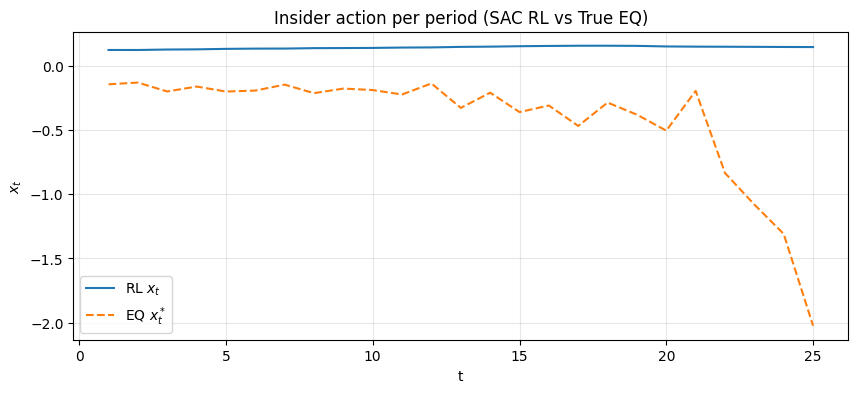

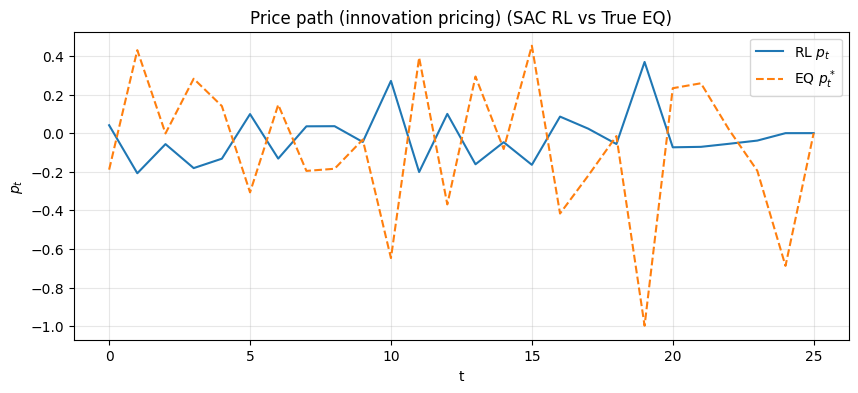

In [ ]:
# 7) Main: train insider vs EQ MM, then MM vs EQ insider, then simulate both with SAC
# -----------------------------
if __name__ == "__main__":
    torch.manual_seed(42); np.random.seed(42)

    T = 25
    p0 = 0.5
    sigma_v = 2.0
    sigma_u = 1.0
    action_scaling = 1.0
    gamma = 0.98 # Note: Using gamma for env reward discounting, SAC uses its own gamma

    # Create a dummy env to get observation and action dimensions
    dummy_env = KyleMultiPeriodAEC(T=T, sigma_v=sigma_v, sigma_u=sigma_u, p0=p0,
                                   action_scaling=action_scaling, gamma=gamma,
                                   train_agent="insider")
    obs_dim = dummy_env.observation_space("insider").shape[0] # Get obs_dim from env
    act_dim = dummy_env.action_space("insider").shape[0] # Get act_dim from env
    dummy_env.close()
    del dummy_env


    # SAC Hyperparameters
    sac_episodes = 5000 # Reduced episodes for faster testing
    sac_lr = 3e-4
    sac_gamma = 0.99 # Standard SAC gamma for value/Q updates
    sac_polyak = 0.995
    sac_buffer_size = int(1e5) # Reduced buffer size for faster testing
    sac_batch_size = 256
    sac_start_steps = 1000 # Reduced start steps
    sac_update_after = 500 # Reduced update after
    sac_update_every = 50
    sac_alpha = 0.2 # Temperature parameter


    # --- Train INSIDER vs equilibrium MM (using SAC) ---
    print("\n--- Training Insider (SAC) vs Equilibrium MM ---")
    env_I = KyleMultiPeriodAEC(T=T, sigma_v=sigma_v, sigma_u=sigma_u, p0=p0,
                               action_scaling=action_scaling, gamma=gamma, # Env gamma
                               train_agent="insider")
    insider_actor = SACActor(obs_dim=obs_dim, act_dim=act_dim, hidden=64)
    insider_critic1 = SACCritic(obs_dim=obs_dim, act_dim=act_dim, hidden=64)
    insider_critic2 = SACCritic(obs_dim=obs_dim, act_dim=act_dim, hidden=64)
    insider_value_net = SACValueNet(obs_dim=obs_dim, hidden=64)
    insider_target_value_net = SACValueNet(obs_dim=obs_dim, hidden=64)
    insider_target_value_net.load_state_dict(insider_value_net.state_dict()) # Initialize target net

    insider_actor, insider_critic1, insider_critic2, insider_value_net = train_sac(
        env_I, insider_actor, insider_critic1, insider_critic2,
        insider_value_net, insider_target_value_net,
        episodes=sac_episodes, lr=sac_lr, gamma=sac_gamma, polyak=sac_polyak,
        buffer_size=sac_buffer_size, batch_size=sac_batch_size, start_steps=sac_start_steps,
        update_after=sac_update_after, update_every=sac_update_every, alpha=sac_alpha
    )
    env_I.close()
    del env_I


    # --- Train MM vs equilibrium INSIDER (using SAC) ---
    print("\n--- Training MM (SAC) vs Equilibrium Insider ---")
    env_M = KyleMultiPeriodAEC(T=T, sigma_v=sigma_v, sigma_u=sigma_u, p0=p0,
                               action_scaling=action_scaling, gamma=gamma, # Env gamma
                               train_agent="market_maker")
    mm_actor = SACActor(obs_dim=obs_dim, act_dim=act_dim, hidden=64)
    mm_critic1 = SACCritic(obs_dim=obs_dim, act_dim=act_dim, hidden=64)
    mm_critic2 = SACCritic(obs_dim=obs_dim, act_dim=act_dim, hidden=64)
    mm_value_net = SACValueNet(obs_dim=obs_dim, hidden=64)
    mm_target_value_net = SACValueNet(obs_dim=obs_dim, hidden=64)
    mm_target_value_net.load_state_dict(mm_value_net.state_dict()) # Initialize target net

    mm_actor, mm_critic1, mm_critic2, mm_value_net = train_sac(
        env_M, mm_actor, mm_critic1, mm_critic2,
        mm_value_net, mm_target_value_net,
        episodes=sac_episodes, lr=sac_lr, gamma=sac_gamma, polyak=sac_polyak,
        buffer_size=sac_buffer_size, batch_size=sac_batch_size, start_steps=sac_start_steps,
        update_after=sac_update_after, update_every=sac_update_every, alpha=sac_alpha
    )
    env_M.close()
    del env_M

    # --- Rollout SAC RL vs EQ (both using same u, v) ---
    print("\n--- Simulating SAC RL vs True EQ ---")
    out = simulate_rl_vs_eq(T=T, p0=p0, sigma_v=sigma_v, sigma_u=sigma_u,
                            insider_net=insider_actor, mm_net=mm_actor, # Pass only actor networks for simulation
                            action_scaling=action_scaling, seed=123)
    plot_paths(out, "(SAC RL vs True EQ)")